In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.0001,
    'batch_size'    : 1000,
    'patience'      : 7,
    'dropout'       : 0.75,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_1000_075_1024_512_256_128_00001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 828)
(631390, 1)
validation
(74368, 828)
(74368, 1)
test
(85358, 828)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/632 [..............................] - ETA: 10:45 - loss: 0.0096 - STD: 1.1103e-04 - MAE: 0.0787

 11/632 [..............................] - ETA: 3s - loss: 0.0099 - STD: 3.3285e-04 - MAE: 0.0784   

 19/632 [..............................] - ETA: 3s - loss: 0.0100 - STD: 6.0210e-04 - MAE: 0.0783

 28/632 [>.............................] - ETA: 3s - loss: 0.0099 - STD: 9.5307e-04 - MAE: 0.0775

 30/632 [>.............................] - ETA: 12s - loss: 0.0098 - STD: 0.0010 - MAE: 0.0773   

 40/632 [>.............................] - ETA: 10s - loss: 0.0098 - STD: 0.0015 - MAE: 0.0775

 47/632 [=>............................] - ETA: 9s - loss: 0.0098 - STD: 0.0019 - MAE: 0.0776 

 55/632 [=>............................] - ETA: 8s - loss: 0.0098 - STD: 0.0024 - MAE: 0.0774

 63/632 [=>............................] - ETA: 7s - loss: 0.0097 - STD: 0.0030 - MAE: 0.0773

 72/632 [==>...........................] - ETA: 6s - loss: 0.0097 - STD: 0.0039 - MAE: 0.0771

 80/632 [==>...........................] - ETA: 6s - loss: 0.0096 - STD: 0.0048 - MAE: 0.0768

 86/632 [===>..........................] - ETA: 6s - loss: 0.0095 - STD: 0.0056 - MAE: 0.0766

 95/632 [===>..........................] - ETA: 6s - loss: 0.0094 - STD: 0.0071 - MAE: 0.0761

104/632 [===>..........................] - ETA: 5s - loss: 0.0093 - STD: 0.0088 - MAE: 0.0758

112/632 [====>.........................] - ETA: 5s - loss: 0.0092 - STD: 0.0103 - MAE: 0.0755

120/632 [====>.........................] - ETA: 5s - loss: 0.0092 - STD: 0.0119 - MAE: 0.0753

129/632 [=====>........................] - ETA: 4s - loss: 0.0091 - STD: 0.0137 - MAE: 0.0749

137/632 [=====>........................] - ETA: 4s - loss: 0.0091 - STD: 0.0151 - MAE: 0.0747

145/632 [=====>........................] - ETA: 4s - loss: 0.0090 - STD: 0.0164 - MAE: 0.0744

152/632 [======>.......................] - ETA: 4s - loss: 0.0090 - STD: 0.0174 - MAE: 0.0743

159/632 [======>.......................] - ETA: 4s - loss: 0.0089 - STD: 0.0184 - MAE: 0.0741

166/632 [======>.......................] - ETA: 4s - loss: 0.0089 - STD: 0.0194 - MAE: 0.0739

173/632 [=======>......................] - ETA: 4s - loss: 0.0089 - STD: 0.0202 - MAE: 0.0738

181/632 [=======>......................] - ETA: 4s - loss: 0.0088 - STD: 0.0212 - MAE: 0.0735

188/632 [=======>......................] - ETA: 3s - loss: 0.0088 - STD: 0.0219 - MAE: 0.0733

195/632 [========>.....................] - ETA: 3s - loss: 0.0087 - STD: 0.0226 - MAE: 0.0731

202/632 [========>.....................] - ETA: 3s - loss: 0.0087 - STD: 0.0233 - MAE: 0.0730

209/632 [========>.....................] - ETA: 3s - loss: 0.0086 - STD: 0.0239 - MAE: 0.0728

217/632 [=========>....................] - ETA: 3s - loss: 0.0086 - STD: 0.0246 - MAE: 0.0725

224/632 [=========>....................] - ETA: 3s - loss: 0.0085 - STD: 0.0251 - MAE: 0.0723

230/632 [=========>....................] - ETA: 3s - loss: 0.0085 - STD: 0.0256 - MAE: 0.0722

237/632 [==========>...................] - ETA: 3s - loss: 0.0085 - STD: 0.0261 - MAE: 0.0720

245/632 [==========>...................] - ETA: 3s - loss: 0.0084 - STD: 0.0268 - MAE: 0.0717

252/632 [==========>...................] - ETA: 3s - loss: 0.0084 - STD: 0.0274 - MAE: 0.0715

259/632 [===========>..................] - ETA: 3s - loss: 0.0083 - STD: 0.0279 - MAE: 0.0713

266/632 [===========>..................] - ETA: 3s - loss: 0.0083 - STD: 0.0285 - MAE: 0.0710

273/632 [===========>..................] - ETA: 3s - loss: 0.0082 - STD: 0.0290 - MAE: 0.0708

280/632 [============>.................] - ETA: 2s - loss: 0.0082 - STD: 0.0295 - MAE: 0.0706

287/632 [============>.................] - ETA: 2s - loss: 0.0082 - STD: 0.0300 - MAE: 0.0703

294/632 [============>.................] - ETA: 2s - loss: 0.0081 - STD: 0.0305 - MAE: 0.0701

301/632 [=============>................] - ETA: 2s - loss: 0.0081 - STD: 0.0310 - MAE: 0.0699

308/632 [=============>................] - ETA: 2s - loss: 0.0080 - STD: 0.0315 - MAE: 0.0697

315/632 [=============>................] - ETA: 2s - loss: 0.0080 - STD: 0.0320 - MAE: 0.0695

322/632 [==============>...............] - ETA: 2s - loss: 0.0079 - STD: 0.0325 - MAE: 0.0692

328/632 [==============>...............] - ETA: 2s - loss: 0.0079 - STD: 0.0330 - MAE: 0.0691

334/632 [==============>...............] - ETA: 2s - loss: 0.0079 - STD: 0.0334 - MAE: 0.0689

340/632 [===============>..............] - ETA: 2s - loss: 0.0079 - STD: 0.0338 - MAE: 0.0687

345/632 [===============>..............] - ETA: 2s - loss: 0.0078 - STD: 0.0342 - MAE: 0.0686

351/632 [===============>..............] - ETA: 2s - loss: 0.0078 - STD: 0.0346 - MAE: 0.0684

358/632 [===============>..............] - ETA: 2s - loss: 0.0078 - STD: 0.0351 - MAE: 0.0682

365/632 [================>.............] - ETA: 2s - loss: 0.0077 - STD: 0.0355 - MAE: 0.0680

372/632 [================>.............] - ETA: 2s - loss: 0.0077 - STD: 0.0360 - MAE: 0.0679

379/632 [================>.............] - ETA: 2s - loss: 0.0077 - STD: 0.0365 - MAE: 0.0677

386/632 [=================>............] - ETA: 2s - loss: 0.0076 - STD: 0.0369 - MAE: 0.0675

393/632 [=================>............] - ETA: 1s - loss: 0.0076 - STD: 0.0373 - MAE: 0.0674

400/632 [=================>............] - ETA: 1s - loss: 0.0076 - STD: 0.0377 - MAE: 0.0672

408/632 [==================>...........] - ETA: 1s - loss: 0.0075 - STD: 0.0381 - MAE: 0.0670

416/632 [==================>...........] - ETA: 1s - loss: 0.0075 - STD: 0.0386 - MAE: 0.0668

424/632 [===================>..........] - ETA: 1s - loss: 0.0075 - STD: 0.0390 - MAE: 0.0666

432/632 [===================>..........] - ETA: 1s - loss: 0.0074 - STD: 0.0394 - MAE: 0.0665

441/632 [===================>..........] - ETA: 1s - loss: 0.0074 - STD: 0.0399 - MAE: 0.0663

450/632 [====================>.........] - ETA: 1s - loss: 0.0074 - STD: 0.0403 - MAE: 0.0661

458/632 [====================>.........] - ETA: 1s - loss: 0.0074 - STD: 0.0407 - MAE: 0.0659

466/632 [=====================>........] - ETA: 1s - loss: 0.0073 - STD: 0.0411 - MAE: 0.0658

475/632 [=====================>........] - ETA: 1s - loss: 0.0073 - STD: 0.0415 - MAE: 0.0656

484/632 [=====================>........] - ETA: 1s - loss: 0.0073 - STD: 0.0418 - MAE: 0.0654

492/632 [======================>.......] - ETA: 1s - loss: 0.0072 - STD: 0.0422 - MAE: 0.0652

500/632 [======================>.......] - ETA: 1s - loss: 0.0072 - STD: 0.0425 - MAE: 0.0651

508/632 [=======================>......] - ETA: 0s - loss: 0.0072 - STD: 0.0428 - MAE: 0.0650

516/632 [=======================>......] - ETA: 0s - loss: 0.0072 - STD: 0.0431 - MAE: 0.0648

525/632 [=======================>......] - ETA: 0s - loss: 0.0071 - STD: 0.0435 - MAE: 0.0647

534/632 [========================>.....] - ETA: 0s - loss: 0.0071 - STD: 0.0438 - MAE: 0.0645

543/632 [========================>.....] - ETA: 0s - loss: 0.0071 - STD: 0.0442 - MAE: 0.0644

551/632 [=========================>....] - ETA: 0s - loss: 0.0071 - STD: 0.0445 - MAE: 0.0643

559/632 [=========================>....] - ETA: 0s - loss: 0.0070 - STD: 0.0447 - MAE: 0.0641

567/632 [=========================>....] - ETA: 0s - loss: 0.0070 - STD: 0.0450 - MAE: 0.0640

575/632 [==========================>...] - ETA: 0s - loss: 0.0070 - STD: 0.0452 - MAE: 0.0639

583/632 [==========================>...] - ETA: 0s - loss: 0.0070 - STD: 0.0455 - MAE: 0.0638

591/632 [===========================>..] - ETA: 0s - loss: 0.0070 - STD: 0.0457 - MAE: 0.0637

599/632 [===========================>..] - ETA: 0s - loss: 0.0069 - STD: 0.0460 - MAE: 0.0636

607/632 [===========================>..] - ETA: 0s - loss: 0.0069 - STD: 0.0462 - MAE: 0.0634

613/632 [============================>.] - ETA: 0s - loss: 0.0069 - STD: 0.0464 - MAE: 0.0634

621/632 [============================>.] - ETA: 0s - loss: 0.0069 - STD: 0.0466 - MAE: 0.0632

629/632 [============================>.] - ETA: 0s - loss: 0.0069 - STD: 0.0469 - MAE: 0.0631

632/632 [==============================] - 6s 9ms/step - loss: 0.0068 - STD: 0.0470 - MAE: 0.0631 - val_loss: 0.0052 - val_STD: 0.0429 - val_MAE: 0.0523


Epoch 2/10000


  1/632 [..............................] - ETA: 16s - loss: 0.0053 - STD: 0.0622 - MAE: 0.0533

  9/632 [..............................] - ETA: 4s - loss: 0.0052 - STD: 0.0646 - MAE: 0.0541 

 16/632 [..............................] - ETA: 4s - loss: 0.0054 - STD: 0.0649 - MAE: 0.0549

 24/632 [>.............................] - ETA: 4s - loss: 0.0053 - STD: 0.0647 - MAE: 0.0547

 32/632 [>.............................] - ETA: 3s - loss: 0.0053 - STD: 0.0647 - MAE: 0.0545

 41/632 [>.............................] - ETA: 3s - loss: 0.0053 - STD: 0.0646 - MAE: 0.0546

 50/632 [=>............................] - ETA: 3s - loss: 0.0053 - STD: 0.0648 - MAE: 0.0544

 59/632 [=>............................] - ETA: 3s - loss: 0.0053 - STD: 0.0650 - MAE: 0.0544

 68/632 [==>...........................] - ETA: 3s - loss: 0.0053 - STD: 0.0650 - MAE: 0.0544

 77/632 [==>...........................] - ETA: 3s - loss: 0.0053 - STD: 0.0650 - MAE: 0.0543

 85/632 [===>..........................] - ETA: 3s - loss: 0.0053 - STD: 0.0651 - MAE: 0.0542

 94/632 [===>..........................] - ETA: 3s - loss: 0.0053 - STD: 0.0651 - MAE: 0.0541

103/632 [===>..........................] - ETA: 3s - loss: 0.0053 - STD: 0.0652 - MAE: 0.0541

112/632 [====>.........................] - ETA: 3s - loss: 0.0053 - STD: 0.0652 - MAE: 0.0541

121/632 [====>.........................] - ETA: 3s - loss: 0.0053 - STD: 0.0653 - MAE: 0.0540

130/632 [=====>........................] - ETA: 3s - loss: 0.0052 - STD: 0.0654 - MAE: 0.0540

139/632 [=====>........................] - ETA: 3s - loss: 0.0052 - STD: 0.0655 - MAE: 0.0540

148/632 [======>.......................] - ETA: 3s - loss: 0.0052 - STD: 0.0655 - MAE: 0.0539

157/632 [======>.......................] - ETA: 2s - loss: 0.0052 - STD: 0.0656 - MAE: 0.0538

166/632 [======>.......................] - ETA: 2s - loss: 0.0052 - STD: 0.0657 - MAE: 0.0537

175/632 [=======>......................] - ETA: 2s - loss: 0.0052 - STD: 0.0658 - MAE: 0.0537

184/632 [=======>......................] - ETA: 2s - loss: 0.0052 - STD: 0.0658 - MAE: 0.0537

193/632 [========>.....................] - ETA: 2s - loss: 0.0052 - STD: 0.0659 - MAE: 0.0536

202/632 [========>.....................] - ETA: 2s - loss: 0.0052 - STD: 0.0661 - MAE: 0.0536

211/632 [=========>....................] - ETA: 2s - loss: 0.0052 - STD: 0.0661 - MAE: 0.0535

220/632 [=========>....................] - ETA: 2s - loss: 0.0052 - STD: 0.0662 - MAE: 0.0535

228/632 [=========>....................] - ETA: 2s - loss: 0.0052 - STD: 0.0663 - MAE: 0.0535

237/632 [==========>...................] - ETA: 2s - loss: 0.0052 - STD: 0.0664 - MAE: 0.0534

246/632 [==========>...................] - ETA: 2s - loss: 0.0052 - STD: 0.0665 - MAE: 0.0534

254/632 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0665 - MAE: 0.0534

262/632 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0666 - MAE: 0.0534

270/632 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0667 - MAE: 0.0533

278/632 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.0668 - MAE: 0.0533

287/632 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0532

295/632 [=============>................] - ETA: 2s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0532

304/632 [=============>................] - ETA: 2s - loss: 0.0051 - STD: 0.0670 - MAE: 0.0531

313/632 [=============>................] - ETA: 1s - loss: 0.0051 - STD: 0.0670 - MAE: 0.0531

321/632 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.0671 - MAE: 0.0531

330/632 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.0671 - MAE: 0.0531

339/632 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0672 - MAE: 0.0530

348/632 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0672 - MAE: 0.0530

357/632 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0673 - MAE: 0.0530

365/632 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0673 - MAE: 0.0530

374/632 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0674 - MAE: 0.0529

383/632 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0675 - MAE: 0.0529

392/632 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0675 - MAE: 0.0529

401/632 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0676 - MAE: 0.0528

410/632 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0677 - MAE: 0.0528

419/632 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0677 - MAE: 0.0527

428/632 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.0678 - MAE: 0.0527

436/632 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.0678 - MAE: 0.0527

445/632 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.0679 - MAE: 0.0527

454/632 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.0680 - MAE: 0.0526

463/632 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.0680 - MAE: 0.0526

472/632 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0681 - MAE: 0.0526

481/632 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0681 - MAE: 0.0526

490/632 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0682 - MAE: 0.0525

499/632 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0682 - MAE: 0.0525

508/632 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0683 - MAE: 0.0525

517/632 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0684 - MAE: 0.0525

526/632 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0684 - MAE: 0.0525

534/632 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0685 - MAE: 0.0525

542/632 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0685 - MAE: 0.0524

551/632 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0686 - MAE: 0.0524

560/632 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0686 - MAE: 0.0524

569/632 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0687 - MAE: 0.0524

577/632 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0687 - MAE: 0.0523

586/632 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0687 - MAE: 0.0523

595/632 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0687 - MAE: 0.0523

604/632 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0688 - MAE: 0.0523

613/632 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0688 - MAE: 0.0522

622/632 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0688 - MAE: 0.0522

631/632 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0689 - MAE: 0.0522

632/632 [==============================] - 4s 7ms/step - loss: 0.0049 - STD: 0.0689 - MAE: 0.0522 - val_loss: 0.0043 - val_STD: 0.0549 - val_MAE: 0.0488


Epoch 3/10000


  1/632 [..............................] - ETA: 15s - loss: 0.0050 - STD: 0.0708 - MAE: 0.0537

  9/632 [..............................] - ETA: 3s - loss: 0.0048 - STD: 0.0714 - MAE: 0.0520 

 18/632 [..............................] - ETA: 3s - loss: 0.0048 - STD: 0.0717 - MAE: 0.0513

 26/632 [>.............................] - ETA: 3s - loss: 0.0048 - STD: 0.0718 - MAE: 0.0513

 35/632 [>.............................] - ETA: 3s - loss: 0.0047 - STD: 0.0717 - MAE: 0.0510

 44/632 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0718 - MAE: 0.0509

 53/632 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0719 - MAE: 0.0508

 62/632 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0719 - MAE: 0.0510

 71/632 [==>...........................] - ETA: 3s - loss: 0.0048 - STD: 0.0719 - MAE: 0.0511

 80/632 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0718 - MAE: 0.0510

 89/632 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0719 - MAE: 0.0511

 98/632 [===>..........................] - ETA: 3s - loss: 0.0048 - STD: 0.0719 - MAE: 0.0511

107/632 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0721 - MAE: 0.0511

116/632 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0722 - MAE: 0.0510

125/632 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0720 - MAE: 0.0509

134/632 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0721 - MAE: 0.0509

143/632 [=====>........................] - ETA: 2s - loss: 0.0047 - STD: 0.0721 - MAE: 0.0510

152/632 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0721 - MAE: 0.0509

161/632 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0721 - MAE: 0.0509

170/632 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0721 - MAE: 0.0508

179/632 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0722 - MAE: 0.0508

188/632 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0722 - MAE: 0.0508

197/632 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0723 - MAE: 0.0508

206/632 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0722 - MAE: 0.0507

215/632 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0723 - MAE: 0.0507

224/632 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0723 - MAE: 0.0507

233/632 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0723 - MAE: 0.0506

242/632 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0724 - MAE: 0.0507

251/632 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0723 - MAE: 0.0507

260/632 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0724 - MAE: 0.0507

269/632 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0724 - MAE: 0.0507

278/632 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0724 - MAE: 0.0507

287/632 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0724 - MAE: 0.0506

296/632 [=============>................] - ETA: 2s - loss: 0.0046 - STD: 0.0724 - MAE: 0.0507

305/632 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0724 - MAE: 0.0506

314/632 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0724 - MAE: 0.0506

323/632 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0725 - MAE: 0.0506

332/632 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0724 - MAE: 0.0506

341/632 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0725 - MAE: 0.0506

350/632 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0725 - MAE: 0.0506

358/632 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0725 - MAE: 0.0506

366/632 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0725 - MAE: 0.0506

375/632 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0724 - MAE: 0.0506

384/632 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0724 - MAE: 0.0505

393/632 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0724 - MAE: 0.0505

401/632 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0724 - MAE: 0.0505

409/632 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0724 - MAE: 0.0505

417/632 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0724 - MAE: 0.0505

426/632 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0724 - MAE: 0.0505

434/632 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0724 - MAE: 0.0505

442/632 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0725 - MAE: 0.0505

451/632 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0725 - MAE: 0.0505

460/632 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0725 - MAE: 0.0505

469/632 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0725 - MAE: 0.0505

478/632 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0725 - MAE: 0.0504

487/632 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0725 - MAE: 0.0504

496/632 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0725 - MAE: 0.0504

505/632 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0725 - MAE: 0.0504

514/632 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0725 - MAE: 0.0504

521/632 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0725 - MAE: 0.0504

529/632 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0726 - MAE: 0.0504

538/632 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0726 - MAE: 0.0504

547/632 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0726 - MAE: 0.0504

556/632 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0726 - MAE: 0.0504

565/632 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0726 - MAE: 0.0503

574/632 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0726 - MAE: 0.0504

583/632 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0726 - MAE: 0.0504

592/632 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0726 - MAE: 0.0504

601/632 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0726 - MAE: 0.0504

610/632 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0726 - MAE: 0.0504

619/632 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0726 - MAE: 0.0504

628/632 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0726 - MAE: 0.0504

632/632 [==============================] - 4s 6ms/step - loss: 0.0046 - STD: 0.0726 - MAE: 0.0504 - val_loss: 0.0042 - val_STD: 0.0553 - val_MAE: 0.0477


Epoch 4/10000


  1/632 [..............................] - ETA: 13s - loss: 0.0043 - STD: 0.0702 - MAE: 0.0497

  9/632 [..............................] - ETA: 4s - loss: 0.0046 - STD: 0.0712 - MAE: 0.0499 

 18/632 [..............................] - ETA: 3s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0496

 26/632 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0497

 34/632 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0497

 43/632 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0497

 51/632 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0498

 59/632 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0497

 67/632 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0498

 75/632 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0499

 83/632 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0500

 92/632 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0500

101/632 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0499

110/632 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0499

119/632 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0499

128/632 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0498

137/632 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0498

146/632 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0498

155/632 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0498

164/632 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0498

173/632 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0497

181/632 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0497

190/632 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0497

199/632 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0497

208/632 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0497

217/632 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0497

225/632 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0731 - MAE: 0.0497

233/632 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0731 - MAE: 0.0497

241/632 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0731 - MAE: 0.0497

250/632 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0732 - MAE: 0.0497

259/632 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0732 - MAE: 0.0497

268/632 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0732 - MAE: 0.0497

277/632 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0733 - MAE: 0.0497

286/632 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0497

295/632 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0496

304/632 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0496

313/632 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0734 - MAE: 0.0496

321/632 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0734 - MAE: 0.0496

330/632 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0496

338/632 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0496

347/632 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0496

356/632 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0496

365/632 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0496

373/632 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0496

382/632 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0496

390/632 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0496

399/632 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0496

408/632 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0496

417/632 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0496

426/632 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0496

435/632 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0496

444/632 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0496

453/632 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0496

462/632 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0495

471/632 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0495

480/632 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0495

489/632 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0495

498/632 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0495

506/632 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0495

515/632 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0495

524/632 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0494

533/632 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0494

542/632 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0494

551/632 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0494

559/632 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0494

567/632 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0494

576/632 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0495

584/632 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0495

592/632 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0495

601/632 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0495

610/632 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0495

619/632 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0495

628/632 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0495

632/632 [==============================] - 4s 7ms/step - loss: 0.0044 - STD: 0.0739 - MAE: 0.0495 - val_loss: 0.0041 - val_STD: 0.0570 - val_MAE: 0.0474


Epoch 5/10000


  1/632 [..............................] - ETA: 15s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0483

  9/632 [..............................] - ETA: 4s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0491 

 17/632 [..............................] - ETA: 4s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0488

 26/632 [>.............................] - ETA: 3s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0490

 35/632 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0745 - MAE: 0.0491

 44/632 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0743 - MAE: 0.0492

 53/632 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0741 - MAE: 0.0492

 62/632 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0740 - MAE: 0.0492

 71/632 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0741 - MAE: 0.0492

 80/632 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0740 - MAE: 0.0493

 89/632 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0742 - MAE: 0.0492

 98/632 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0743 - MAE: 0.0493

107/632 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0743 - MAE: 0.0491

116/632 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0743 - MAE: 0.0491

125/632 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0490

134/632 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0490

143/632 [=====>........................] - ETA: 2s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0490

152/632 [======>.......................] - ETA: 2s - loss: 0.0043 - STD: 0.0744 - MAE: 0.0490

161/632 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0744 - MAE: 0.0491

170/632 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0744 - MAE: 0.0490

179/632 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0744 - MAE: 0.0490

187/632 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0744 - MAE: 0.0490

196/632 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0744 - MAE: 0.0490

205/632 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0744 - MAE: 0.0490

213/632 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0490

222/632 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0490

231/632 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0490

239/632 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0490

248/632 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0490

257/632 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0490

266/632 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0490

275/632 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0490

284/632 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0490

292/632 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0490

301/632 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0491

310/632 [=============>................] - ETA: 1s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0491

319/632 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0491

327/632 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0491

335/632 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0491

344/632 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0491

353/632 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0490

362/632 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0490

371/632 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0491

380/632 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0491

389/632 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0491

398/632 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0491

407/632 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0491

416/632 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0491

425/632 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0491

434/632 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0491

443/632 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0491

451/632 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0491

459/632 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0491

468/632 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0491

477/632 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0491

486/632 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0491

495/632 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0491

504/632 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0491

513/632 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0491

522/632 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0491

531/632 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0491

540/632 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0491

549/632 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0490

558/632 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0490

567/632 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0490

576/632 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0490

585/632 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0490

594/632 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0490

603/632 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0491

612/632 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0491

621/632 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0491

630/632 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0491

632/632 [==============================] - 4s 6ms/step - loss: 0.0043 - STD: 0.0746 - MAE: 0.0491 - val_loss: 0.0041 - val_STD: 0.0564 - val_MAE: 0.0470


Epoch 6/10000


  1/632 [..............................] - ETA: 15s - loss: 0.0051 - STD: 0.0716 - MAE: 0.0518

  9/632 [..............................] - ETA: 3s - loss: 0.0044 - STD: 0.0752 - MAE: 0.0494 

 18/632 [..............................] - ETA: 3s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0485

 26/632 [>.............................] - ETA: 3s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0488

 34/632 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0485

 42/632 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0486

 50/632 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0484

 59/632 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0485

 67/632 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0486

 75/632 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0484

 83/632 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0484

 91/632 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0484

 99/632 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0485

107/632 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0484

115/632 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0485

123/632 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0484

131/632 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0484

139/632 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0485

148/632 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0485

157/632 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0484

165/632 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0485

173/632 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0484

181/632 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0485

189/632 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0485

197/632 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0748 - MAE: 0.0485

205/632 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0748 - MAE: 0.0485

214/632 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0749 - MAE: 0.0485

223/632 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0749 - MAE: 0.0485

231/632 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0749 - MAE: 0.0485

239/632 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0749 - MAE: 0.0485

248/632 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0749 - MAE: 0.0485

257/632 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0749 - MAE: 0.0485

265/632 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0749 - MAE: 0.0485

273/632 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0749 - MAE: 0.0485

282/632 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0748 - MAE: 0.0485

290/632 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0749 - MAE: 0.0485

298/632 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0749 - MAE: 0.0486

306/632 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0750 - MAE: 0.0486

314/632 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0750 - MAE: 0.0486

322/632 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0750 - MAE: 0.0486

330/632 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0751 - MAE: 0.0486

339/632 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0751 - MAE: 0.0486

347/632 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0751 - MAE: 0.0486

356/632 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0751 - MAE: 0.0486

365/632 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0751 - MAE: 0.0486

374/632 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0751 - MAE: 0.0486

382/632 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0486

391/632 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0486

400/632 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0486

409/632 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0486

418/632 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0486

427/632 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0487

436/632 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0487

444/632 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0487

453/632 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0487

461/632 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0487

470/632 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0487

479/632 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0487

488/632 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0486

497/632 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0486

505/632 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0486

514/632 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0487

522/632 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0487

530/632 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0487

538/632 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0751 - MAE: 0.0486

547/632 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0751 - MAE: 0.0486

556/632 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0751 - MAE: 0.0486

565/632 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0751 - MAE: 0.0486

574/632 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0751 - MAE: 0.0486

583/632 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0751 - MAE: 0.0486

591/632 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0751 - MAE: 0.0486

600/632 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0751 - MAE: 0.0486

608/632 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0751 - MAE: 0.0486

616/632 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0751 - MAE: 0.0486

624/632 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0751 - MAE: 0.0486

632/632 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0751 - MAE: 0.0486

632/632 [==============================] - 4s 7ms/step - loss: 0.0043 - STD: 0.0751 - MAE: 0.0486 - val_loss: 0.0040 - val_STD: 0.0592 - val_MAE: 0.0471


Epoch 7/10000


  1/632 [..............................] - ETA: 14s - loss: 0.0043 - STD: 0.0762 - MAE: 0.0484

  9/632 [..............................] - ETA: 4s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0485 

 18/632 [..............................] - ETA: 3s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0486

 26/632 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0485

 34/632 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0485

 43/632 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0485

 52/632 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0484

 61/632 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0483

 70/632 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0483

 79/632 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0484

 88/632 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0484

 96/632 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0484

104/632 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0485

113/632 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0485

122/632 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0485

130/632 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0485

139/632 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0485

148/632 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0485

157/632 [======>.......................] - ETA: 2s - loss: 0.0043 - STD: 0.0754 - MAE: 0.0485

166/632 [======>.......................] - ETA: 2s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0486

174/632 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0486

182/632 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0486

191/632 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0486

200/632 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0486

209/632 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0754 - MAE: 0.0486

218/632 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0485

227/632 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0485

235/632 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0485

244/632 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0485

253/632 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0485

262/632 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0485

271/632 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0485

280/632 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0485

289/632 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0485

298/632 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0486

307/632 [=============>................] - ETA: 1s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0485

315/632 [=============>................] - ETA: 1s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0485

324/632 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0485

332/632 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0485

341/632 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0485

350/632 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0485

359/632 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0485

367/632 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0485

376/632 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0485

385/632 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0485

394/632 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0485

403/632 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0485

412/632 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0485

421/632 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0485

430/632 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0485

439/632 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0485

448/632 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0484

457/632 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0484

466/632 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0484

475/632 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0484

484/632 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0484

492/632 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0484

501/632 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0484

510/632 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0484

519/632 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0483

528/632 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0484

537/632 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0483

546/632 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0483

555/632 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0483

564/632 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0483

573/632 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0484

582/632 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0484

591/632 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0484

600/632 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0484

609/632 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0484

618/632 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0484

626/632 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0484

632/632 [==============================] - 4s 6ms/step - loss: 0.0042 - STD: 0.0754 - MAE: 0.0484 - val_loss: 0.0040 - val_STD: 0.0614 - val_MAE: 0.0475


Epoch 8/10000


  1/632 [..............................] - ETA: 13s - loss: 0.0045 - STD: 0.0802 - MAE: 0.0516

  9/632 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0757 - MAE: 0.0490 

 18/632 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0760 - MAE: 0.0483

 27/632 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0756 - MAE: 0.0482

 36/632 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0484

 44/632 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0487

 52/632 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0486

 60/632 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0485

 68/632 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0486

 77/632 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0486

 86/632 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0486

 95/632 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0485

103/632 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0485

112/632 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0485

121/632 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0485

129/632 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0485

138/632 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0484

147/632 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0485

156/632 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0485

165/632 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0485

174/632 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0484

183/632 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0484

192/632 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0483

201/632 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0483

210/632 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0483

218/632 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0483

226/632 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0483

235/632 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0483

244/632 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0483

252/632 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0483

261/632 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0483

270/632 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0483

279/632 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0483

288/632 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0483

297/632 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0483

305/632 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0483

314/632 [=============>................] - ETA: 1s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0483

323/632 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0483

331/632 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0484

339/632 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0484

348/632 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0484

356/632 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0484

363/632 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0484

372/632 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0484

380/632 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0484

388/632 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0484

396/632 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0484

405/632 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0484

413/632 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0484

422/632 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0484

430/632 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0484

439/632 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0484

447/632 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0484

456/632 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0484

464/632 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0484

473/632 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0484

481/632 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0484

490/632 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0484

499/632 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0484

508/632 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0484

516/632 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0484

525/632 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0484

533/632 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0483

542/632 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0483

551/632 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0483

559/632 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0483

567/632 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0483

575/632 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0483

583/632 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0483

592/632 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0483

601/632 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0483

610/632 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0483

619/632 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0483

628/632 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0483

632/632 [==============================] - 4s 7ms/step - loss: 0.0042 - STD: 0.0755 - MAE: 0.0483 - val_loss: 0.0041 - val_STD: 0.0564 - val_MAE: 0.0466


Epoch 9/10000


  1/632 [..............................] - ETA: 15s - loss: 0.0045 - STD: 0.0733 - MAE: 0.0469

 10/632 [..............................] - ETA: 3s - loss: 0.0043 - STD: 0.0777 - MAE: 0.0481 

 19/632 [..............................] - ETA: 3s - loss: 0.0041 - STD: 0.0769 - MAE: 0.0480

 27/632 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0481

 36/632 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0481

 45/632 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0480

 54/632 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0760 - MAE: 0.0480

 63/632 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0479

 72/632 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0480

 80/632 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0480

 89/632 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0480

 98/632 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0480

105/632 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0480

114/632 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0480

123/632 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0480

132/632 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0480

141/632 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0757 - MAE: 0.0480

150/632 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0757 - MAE: 0.0480

159/632 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0757 - MAE: 0.0480

168/632 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0757 - MAE: 0.0480

177/632 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0756 - MAE: 0.0480

185/632 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0480

194/632 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0480

203/632 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0480

212/632 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0480

220/632 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0480

229/632 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0480

238/632 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0480

246/632 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0479

255/632 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0479

264/632 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0479

273/632 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0479

282/632 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0479

291/632 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0480

300/632 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0479

308/632 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0480

317/632 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0480

326/632 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0480

335/632 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0758 - MAE: 0.0480

344/632 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0758 - MAE: 0.0480

353/632 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0758 - MAE: 0.0480

362/632 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0758 - MAE: 0.0480

371/632 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0480

380/632 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0480

389/632 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0758 - MAE: 0.0480

397/632 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0480

406/632 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0480

415/632 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0480

423/632 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0480

432/632 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0480

440/632 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0758 - MAE: 0.0480

449/632 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0480

458/632 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0480

467/632 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0480

476/632 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0480

485/632 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0480

494/632 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0479

503/632 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0479

512/632 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0479

521/632 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0479

530/632 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0479

539/632 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0479

548/632 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0479

557/632 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0479

566/632 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0480

575/632 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0480

583/632 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0480

592/632 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0480

601/632 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0480

610/632 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0480

619/632 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0480

627/632 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0480

632/632 [==============================] - 4s 7ms/step - loss: 0.0041 - STD: 0.0759 - MAE: 0.0480 - val_loss: 0.0040 - val_STD: 0.0576 - val_MAE: 0.0463


Epoch 10/10000


  1/632 [..............................] - ETA: 15s - loss: 0.0041 - STD: 0.0716 - MAE: 0.0478

  9/632 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0486 

 18/632 [..............................] - ETA: 3s - loss: 0.0042 - STD: 0.0758 - MAE: 0.0484

 26/632 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0757 - MAE: 0.0485

 35/632 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0482

 44/632 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0482

 53/632 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0756 - MAE: 0.0482

 61/632 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0757 - MAE: 0.0481

 69/632 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0757 - MAE: 0.0481

 77/632 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0759 - MAE: 0.0481

 86/632 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0760 - MAE: 0.0480

 95/632 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0480

104/632 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0480

112/632 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0479

121/632 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0480

130/632 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0480

139/632 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0479

148/632 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0479

157/632 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0479

166/632 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0479

174/632 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0479

183/632 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0479

192/632 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0479

200/632 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0479

208/632 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0479

217/632 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0479

226/632 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0478

235/632 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0478

243/632 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0478

251/632 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0478

259/632 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0478

268/632 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0478

277/632 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0478

286/632 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0477

295/632 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0477

304/632 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0478

313/632 [=============>................] - ETA: 1s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0478

321/632 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0478

329/632 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0478

337/632 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0478

346/632 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0478

355/632 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0478

363/632 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0478

372/632 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0478

381/632 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0478

390/632 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0478

399/632 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0478

407/632 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0478

415/632 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0478

423/632 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0478

432/632 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0478

441/632 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0478

450/632 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0478

459/632 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0478

468/632 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0478

476/632 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0478

484/632 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0478

493/632 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0478

502/632 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0477

511/632 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0477

519/632 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0477

528/632 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0477

537/632 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0478

546/632 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0478

555/632 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0477

564/632 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0477

572/632 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0477

580/632 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0477

589/632 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0477

598/632 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0477

607/632 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0478

616/632 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0478

625/632 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0478

632/632 [==============================] - 4s 7ms/step - loss: 0.0041 - STD: 0.0761 - MAE: 0.0478 - val_loss: 0.0040 - val_STD: 0.0576 - val_MAE: 0.0461


Epoch 11/10000


  1/632 [..............................] - ETA: 13s - loss: 0.0038 - STD: 0.0761 - MAE: 0.0458

  9/632 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0749 - MAE: 0.0467 

 18/632 [..............................] - ETA: 3s - loss: 0.0040 - STD: 0.0754 - MAE: 0.0474

 27/632 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0474

 36/632 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0477

 45/632 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0477

 54/632 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0477

 62/632 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0476

 71/632 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0474

 80/632 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0475

 89/632 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0475

 98/632 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0475

106/632 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0475

115/632 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0475

123/632 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0475

131/632 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0475

140/632 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0475

149/632 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0475

158/632 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0475

166/632 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0475

175/632 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0475

184/632 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0475

193/632 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0475

202/632 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0475

211/632 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0475

219/632 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0475

228/632 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0475

236/632 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0476

244/632 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0475

253/632 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0475

262/632 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0475

271/632 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0475

280/632 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0475

289/632 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0475

298/632 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0476

307/632 [=============>................] - ETA: 1s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0476

316/632 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0476

325/632 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0476

334/632 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0476

343/632 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0476

352/632 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0476

362/632 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0476

370/632 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0476

379/632 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0476

388/632 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0476

396/632 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0476

405/632 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0476

414/632 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0476

423/632 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0476

432/632 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0476

441/632 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0476

450/632 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0476

458/632 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0476

467/632 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0476

476/632 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0476

485/632 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0476

494/632 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0476

503/632 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0476

512/632 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0476

521/632 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0476

530/632 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0477

539/632 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0477

548/632 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0477

557/632 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0477

566/632 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0476

575/632 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0476

584/632 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0476

593/632 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0476

602/632 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0476

611/632 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0476

620/632 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0477

629/632 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0477

632/632 [==============================] - 4s 6ms/step - loss: 0.0041 - STD: 0.0761 - MAE: 0.0476 - val_loss: 0.0039 - val_STD: 0.0624 - val_MAE: 0.0467


Epoch 12/10000


  1/632 [..............................] - ETA: 14s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0463

 10/632 [..............................] - ETA: 3s - loss: 0.0041 - STD: 0.0764 - MAE: 0.0473 

 18/632 [..............................] - ETA: 3s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0477

 27/632 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0760 - MAE: 0.0480

 35/632 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0480

 44/632 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0765 - MAE: 0.0479

 53/632 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0478

 62/632 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0477

 70/632 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0477

 78/632 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0476

 86/632 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0476

 94/632 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0476

102/632 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0476

110/632 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0475

119/632 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0475

127/632 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0475

135/632 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0475

143/632 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0475

152/632 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0476

161/632 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0476

169/632 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0476

177/632 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0475

186/632 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0476

195/632 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0475

204/632 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0475

213/632 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0475

222/632 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0475

231/632 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0475

240/632 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0475

249/632 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0476

257/632 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0476

266/632 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0476

274/632 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0476

282/632 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0475

290/632 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0475

299/632 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0475

308/632 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0475

317/632 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0475

326/632 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0475

334/632 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0475

342/632 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0475

351/632 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0475

359/632 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0475

367/632 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0475

376/632 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0475

385/632 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0764 - MAE: 0.0475

393/632 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0475

401/632 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0475

410/632 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0475

418/632 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0475

427/632 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0764 - MAE: 0.0475

436/632 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0764 - MAE: 0.0475

444/632 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0764 - MAE: 0.0474

453/632 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0764 - MAE: 0.0474

461/632 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0764 - MAE: 0.0474

469/632 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0764 - MAE: 0.0474

477/632 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0764 - MAE: 0.0474

486/632 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0764 - MAE: 0.0474

495/632 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0764 - MAE: 0.0474

503/632 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0764 - MAE: 0.0474

511/632 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0765 - MAE: 0.0474

520/632 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0765 - MAE: 0.0474

528/632 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0765 - MAE: 0.0474

536/632 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0764 - MAE: 0.0474

544/632 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0765 - MAE: 0.0474

553/632 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0765 - MAE: 0.0474

562/632 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0764 - MAE: 0.0474

570/632 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0765 - MAE: 0.0474

578/632 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0764 - MAE: 0.0474

586/632 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0765 - MAE: 0.0474

595/632 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0765 - MAE: 0.0474

603/632 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0765 - MAE: 0.0474

611/632 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0765 - MAE: 0.0474

620/632 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0765 - MAE: 0.0474

629/632 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0765 - MAE: 0.0474

632/632 [==============================] - 4s 7ms/step - loss: 0.0041 - STD: 0.0765 - MAE: 0.0474 - val_loss: 0.0042 - val_STD: 0.0662 - val_MAE: 0.0490


Epoch 13/10000


  1/632 [..............................] - ETA: 14s - loss: 0.0046 - STD: 0.0824 - MAE: 0.0516

 10/632 [..............................] - ETA: 3s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0469 

 19/632 [..............................] - ETA: 3s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0471

 27/632 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469

 35/632 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0469

 43/632 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0469

 52/632 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0469

 61/632 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0470

 70/632 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0470

 78/632 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0471

 87/632 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0471

 95/632 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0471

103/632 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0472

112/632 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0472

121/632 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0472

130/632 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0472

138/632 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0472

146/632 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0472

154/632 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0472

162/632 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0472

170/632 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0472

177/632 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0472

184/632 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0472

189/632 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0472

197/632 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0472

204/632 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0472

212/632 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0472

220/632 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0472

228/632 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0471

236/632 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0472

244/632 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0472

251/632 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0472

259/632 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0472

268/632 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0472

277/632 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0472

286/632 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0472

295/632 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0473

304/632 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0473

313/632 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0473

322/632 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0473

331/632 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0474

340/632 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0474

349/632 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0474

358/632 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0474

367/632 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0474

375/632 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0475

383/632 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0475

391/632 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0475

399/632 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0475

408/632 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0475

417/632 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0474

425/632 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0474

433/632 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0474

442/632 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0474

451/632 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0764 - MAE: 0.0474

459/632 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0764 - MAE: 0.0474

467/632 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0764 - MAE: 0.0474

475/632 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0764 - MAE: 0.0474

484/632 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0764 - MAE: 0.0474

493/632 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0764 - MAE: 0.0474

502/632 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0764 - MAE: 0.0474

512/632 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0764 - MAE: 0.0474

521/632 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0764 - MAE: 0.0474

530/632 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0764 - MAE: 0.0474

539/632 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0764 - MAE: 0.0474

548/632 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0764 - MAE: 0.0474

557/632 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0764 - MAE: 0.0474

566/632 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0474

575/632 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0474

584/632 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0474

592/632 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0474

600/632 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0474

609/632 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0473

618/632 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0473

627/632 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0473

632/632 [==============================] - 4s 7ms/step - loss: 0.0040 - STD: 0.0765 - MAE: 0.0473 - val_loss: 0.0039 - val_STD: 0.0634 - val_MAE: 0.0467


Epoch 14/10000


  1/632 [..............................] - ETA: 17s - loss: 0.0037 - STD: 0.0813 - MAE: 0.0455

  9/632 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0469 

 17/632 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0468

 26/632 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0468

 35/632 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0468

 44/632 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0470

 53/632 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0470

 62/632 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0469

 71/632 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0470

 80/632 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0469

 89/632 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0470

 98/632 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0471

107/632 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0470

116/632 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0471

125/632 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0471

133/632 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0471

141/632 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0471

150/632 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0471

159/632 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0471

167/632 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0471

174/632 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0471

182/632 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0471

190/632 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0471

197/632 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0472

205/632 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0472

212/632 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0472

220/632 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0472

228/632 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0472

236/632 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0472

245/632 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0472

254/632 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0472

262/632 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0472

270/632 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0472

278/632 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0472

287/632 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0472

296/632 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0472

305/632 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0472

314/632 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0472

323/632 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0472

332/632 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0472

341/632 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0472

348/632 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0472

357/632 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0472

366/632 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0472

375/632 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0472

384/632 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0472

393/632 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0472

402/632 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0472

410/632 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0472

419/632 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0472

428/632 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0472

437/632 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0472

446/632 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0472

455/632 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0472

464/632 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0471

473/632 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0471

482/632 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0472

491/632 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0472

500/632 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0471

509/632 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0471

518/632 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0471

527/632 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0471

536/632 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0471

545/632 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0471

554/632 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0471

563/632 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0471

572/632 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0472

581/632 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0471

590/632 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0471

599/632 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0471

608/632 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0471

617/632 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0471

626/632 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0471

632/632 [==============================] - 4s 6ms/step - loss: 0.0040 - STD: 0.0768 - MAE: 0.0471 - val_loss: 0.0040 - val_STD: 0.0590 - val_MAE: 0.0461


Epoch 15/10000


  1/632 [..............................] - ETA: 15s - loss: 0.0047 - STD: 0.0715 - MAE: 0.0494

  8/632 [..............................] - ETA: 5s - loss: 0.0043 - STD: 0.0777 - MAE: 0.0486 

 17/632 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0775 - MAE: 0.0476

 26/632 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0473

 35/632 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0474

 44/632 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0473

 53/632 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0472

 62/632 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0472

 71/632 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0472

 80/632 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0471

 89/632 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0470

 98/632 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0471

107/632 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0471

116/632 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0471

125/632 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0471

134/632 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0471

143/632 [=====>........................] - ETA: 2s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0471

152/632 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0470

161/632 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0470

170/632 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0470

180/632 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0470

189/632 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0470

198/632 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0470

207/632 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0469

216/632 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0470

225/632 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0469

234/632 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0469

243/632 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0469

252/632 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0469

261/632 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0469

270/632 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0469

279/632 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0469

288/632 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0469

297/632 [=============>................] - ETA: 1s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0469

306/632 [=============>................] - ETA: 1s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0469

315/632 [=============>................] - ETA: 1s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0469

324/632 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0469

334/632 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0469

343/632 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0469

352/632 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0469

361/632 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0469

370/632 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0469

379/632 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0470

388/632 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0469

397/632 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0470

406/632 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0470

415/632 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0470

424/632 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0470

433/632 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0470

442/632 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0471

451/632 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0471

460/632 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0471

469/632 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0471

477/632 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0471

486/632 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0471

495/632 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0471

504/632 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0471

513/632 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0471

522/632 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0471

531/632 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0471

540/632 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0471

549/632 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0471

558/632 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0471

567/632 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0470

576/632 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0470

585/632 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0470

594/632 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0471

603/632 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0471

612/632 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0470

621/632 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0470

630/632 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0470

632/632 [==============================] - 4s 6ms/step - loss: 0.0040 - STD: 0.0768 - MAE: 0.0470 - val_loss: 0.0039 - val_STD: 0.0607 - val_MAE: 0.0459


Epoch 16/10000


  1/632 [..............................] - ETA: 13s - loss: 0.0045 - STD: 0.0755 - MAE: 0.0474

 10/632 [..............................] - ETA: 3s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0464 

 19/632 [..............................] - ETA: 3s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0466

 27/632 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0467

 36/632 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0464

 43/632 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0463

 51/632 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0463

 60/632 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0463

 69/632 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0464

 78/632 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0464

 86/632 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0464

 94/632 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0465

103/632 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0466

112/632 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0466

121/632 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0466

130/632 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0466

139/632 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0466

148/632 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0466

157/632 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0466

166/632 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0467

175/632 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0467

184/632 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0467

193/632 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0772 - MAE: 0.0467

202/632 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0467

211/632 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0467

220/632 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0467

229/632 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0467

238/632 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0467

247/632 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0467

256/632 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0468

265/632 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0468

274/632 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0468

283/632 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0468

292/632 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0468

301/632 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0468

310/632 [=============>................] - ETA: 1s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0468

319/632 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0469

328/632 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0469

337/632 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0469

346/632 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0469

355/632 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0469

364/632 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0469

373/632 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0469

382/632 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0469

391/632 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0469

400/632 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0469

409/632 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0469

418/632 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0469

427/632 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0469

436/632 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0468

445/632 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0468

454/632 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0468

463/632 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0468

472/632 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0468

481/632 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0468

490/632 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0468

498/632 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0468

507/632 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0468

516/632 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0468

525/632 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0468

534/632 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0469

543/632 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0469

552/632 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0469

561/632 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0469

570/632 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0469

578/632 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0469

587/632 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0469

595/632 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0469

604/632 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0469

613/632 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0469

621/632 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0469

629/632 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0469

632/632 [==============================] - 4s 6ms/step - loss: 0.0040 - STD: 0.0770 - MAE: 0.0469 - val_loss: 0.0039 - val_STD: 0.0643 - val_MAE: 0.0468


Epoch 17/10000


  1/632 [..............................] - ETA: 14s - loss: 0.0038 - STD: 0.0808 - MAE: 0.0467

  8/632 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0465 

 15/632 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0470

 20/632 [..............................] - ETA: 5s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0471

 29/632 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0468

 37/632 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0467

 45/632 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0468

 51/632 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0772 - MAE: 0.0468

 60/632 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0467

 69/632 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0466

 77/632 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0467

 85/632 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0467

 94/632 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0467

103/632 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0468

111/632 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0467

118/632 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0772 - MAE: 0.0468

125/632 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0468

132/632 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0469

139/632 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0469

147/632 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0469

154/632 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0469

161/632 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0469

168/632 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0469

176/632 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0469

184/632 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0468

191/632 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0468

199/632 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0468

207/632 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0469

215/632 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0469

223/632 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0469

231/632 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0469

238/632 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0469

246/632 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0469

253/632 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0469

260/632 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0469

268/632 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0469

276/632 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0469

283/632 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0470

290/632 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0470

297/632 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0469

303/632 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0469

309/632 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0470

314/632 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0470

319/632 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0469

326/632 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0469

333/632 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0469

340/632 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0469

348/632 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0469

356/632 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0469

364/632 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0470

371/632 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0469

379/632 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0469

387/632 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0469

396/632 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0469

404/632 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0469

413/632 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0469

422/632 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0469

430/632 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0469

438/632 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0469

447/632 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0469

455/632 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0468

464/632 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0469

473/632 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0468

481/632 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0468

490/632 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0468

499/632 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0468

508/632 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0468

517/632 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0468

526/632 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0468

534/632 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0468

542/632 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0468

550/632 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0468

558/632 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0468

566/632 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0468

575/632 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0468

584/632 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0468

593/632 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0468

602/632 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0468

611/632 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0468

620/632 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0468

629/632 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0468

632/632 [==============================] - 5s 7ms/step - loss: 0.0040 - STD: 0.0770 - MAE: 0.0468 - val_loss: 0.0040 - val_STD: 0.0595 - val_MAE: 0.0459


Epoch 18/10000


  1/632 [..............................] - ETA: 16s - loss: 0.0039 - STD: 0.0753 - MAE: 0.0455

  9/632 [..............................] - ETA: 3s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0468 

 18/632 [..............................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0462

 26/632 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0466

 34/632 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0468

 43/632 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0469

 52/632 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

 61/632 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0470

 70/632 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0469

 79/632 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0469

 88/632 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0470

 97/632 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0772 - MAE: 0.0469

106/632 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0772 - MAE: 0.0469

115/632 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0469

123/632 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0469

131/632 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0469

139/632 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0470

147/632 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0469

155/632 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0469

163/632 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0469

171/632 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0469

178/632 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0469

186/632 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0469

193/632 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0468

201/632 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0468

209/632 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0468

217/632 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0468

224/632 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0468

231/632 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0468

238/632 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0468

245/632 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0468

253/632 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0468

261/632 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0468

269/632 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0467

276/632 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0468

284/632 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0468

291/632 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0468

299/632 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0468

307/632 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0772 - MAE: 0.0468

315/632 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0467

323/632 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0467

330/632 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0467

338/632 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0467

346/632 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0467

353/632 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0467

359/632 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0467

367/632 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0467

375/632 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0467

383/632 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0467

391/632 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0467

399/632 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0467

407/632 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0466

414/632 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0466

422/632 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0466

431/632 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0466

440/632 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0466

449/632 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0466

458/632 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0466

467/632 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0466

476/632 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0466

485/632 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0466

494/632 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0466

503/632 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0466

511/632 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0466

519/632 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0466

527/632 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0466

535/632 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0466

542/632 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0466

550/632 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0466

558/632 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0466

566/632 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0466

573/632 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0466

581/632 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0466

589/632 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0466

597/632 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0466

605/632 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0466

613/632 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0467

621/632 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0466

629/632 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0466

632/632 [==============================] - 4s 7ms/step - loss: 0.0039 - STD: 0.0772 - MAE: 0.0466 - val_loss: 0.0041 - val_STD: 0.0663 - val_MAE: 0.0480


Epoch 19/10000


  1/632 [..............................] - ETA: 15s - loss: 0.0039 - STD: 0.0795 - MAE: 0.0488

  9/632 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0478 

 17/632 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0476

 25/632 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0473

 33/632 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0471

 41/632 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0772 - MAE: 0.0470

 48/632 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0468

 56/632 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0467

 64/632 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0467

 72/632 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0467

 79/632 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0466

 87/632 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0465

 95/632 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0465

103/632 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0466

111/632 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0466

119/632 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0466

127/632 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0466

134/632 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0466

142/632 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0466

149/632 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0466

157/632 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0466

164/632 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0466

172/632 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0466

179/632 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0466

188/632 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0466

197/632 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0465

205/632 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0465

214/632 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0465

223/632 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0465

231/632 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0465

239/632 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0465

247/632 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0465

255/632 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0465

263/632 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0465

272/632 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0465

281/632 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0465

290/632 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0465

298/632 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0465

305/632 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0465

312/632 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0464

319/632 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0464

326/632 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0464

334/632 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0465

341/632 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0465

349/632 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0465

357/632 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0465

365/632 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0465

373/632 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0465

380/632 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0466

387/632 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0466

394/632 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0466

401/632 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0466

408/632 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0466

415/632 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0466

422/632 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0466

429/632 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0466

436/632 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0466

443/632 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0466

451/632 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0466

458/632 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0466

465/632 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0466

472/632 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0466

480/632 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0465

488/632 [======================>.......] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0465

496/632 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0465

504/632 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0465

512/632 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0465

520/632 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0465

527/632 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0465

534/632 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0465

541/632 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0465

549/632 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0465

557/632 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0465

565/632 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0465

573/632 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0465

581/632 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0465

589/632 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0465

597/632 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0465

605/632 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0465

613/632 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0465

621/632 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0465

629/632 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0465

632/632 [==============================] - 5s 7ms/step - loss: 0.0039 - STD: 0.0773 - MAE: 0.0465 - val_loss: 0.0039 - val_STD: 0.0636 - val_MAE: 0.0462


Epoch 20/10000


  1/632 [..............................] - ETA: 15s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0442

  8/632 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0779 - MAE: 0.0461 

 16/632 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0464

 23/632 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0464

 31/632 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0466

 38/632 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0464

 46/632 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0464

 54/632 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0465

 62/632 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0468

 70/632 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0470

 78/632 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0471

 86/632 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0470

 94/632 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0470

101/632 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0471

109/632 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0470

116/632 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0471

124/632 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0471

132/632 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0470

140/632 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0470

148/632 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0469

155/632 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0469

162/632 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0469

169/632 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0469

176/632 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0469

183/632 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0469

190/632 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0469

197/632 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0469

204/632 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0468

212/632 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0468

219/632 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0468

226/632 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0468

233/632 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0468

241/632 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0467

248/632 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0467

255/632 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0467

263/632 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0467

270/632 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0467

278/632 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0467

286/632 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0467

294/632 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0467

302/632 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0467

310/632 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0466

318/632 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0466

326/632 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0466

333/632 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0467

340/632 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0466

348/632 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0466

356/632 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0466

364/632 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0466

372/632 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0466

380/632 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0466

387/632 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0466

394/632 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0466

402/632 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0466

410/632 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0466

418/632 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0466

425/632 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0466

433/632 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0466

441/632 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0466

448/632 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0466

455/632 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0466

462/632 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0466

470/632 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0466

478/632 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0466

485/632 [======================>.......] - ETA: 1s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0466

493/632 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0465

501/632 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0465

508/632 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0465

516/632 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0465

524/632 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0465

531/632 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0465

539/632 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0465

546/632 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0465

554/632 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0465

562/632 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0465

569/632 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0465

577/632 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0465

585/632 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0465

593/632 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0465

600/632 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0465

608/632 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0465

616/632 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0464

623/632 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0464

631/632 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0464

632/632 [==============================] - 5s 8ms/step - loss: 0.0039 - STD: 0.0773 - MAE: 0.0464 - val_loss: 0.0038 - val_STD: 0.0615 - val_MAE: 0.0456


Epoch 21/10000


  1/632 [..............................] - ETA: 16s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0455

  8/632 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0461 

 15/632 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0460

 22/632 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0460

 29/632 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0458

 36/632 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0457

 43/632 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0456

 50/632 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0457

 58/632 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0459

 65/632 [==>...........................] - ETA: 4s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0460

 72/632 [==>...........................] - ETA: 4s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0461

 80/632 [==>...........................] - ETA: 4s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0461

 87/632 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0462

 94/632 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0462

101/632 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0462

109/632 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0462

117/632 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0462

124/632 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0462

132/632 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0462

140/632 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0779 - MAE: 0.0462

147/632 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0779 - MAE: 0.0462

154/632 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0779 - MAE: 0.0463

162/632 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0779 - MAE: 0.0463

169/632 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0463

176/632 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0464

183/632 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0463

191/632 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0463

198/632 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0463

205/632 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0463

213/632 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0463

221/632 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0463

229/632 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0779 - MAE: 0.0464

237/632 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0464

244/632 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0464

251/632 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0465

259/632 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0465

266/632 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0465

273/632 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0464

281/632 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0464

288/632 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0464

296/632 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0464

304/632 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0464

312/632 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0464

320/632 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0464

328/632 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0465

336/632 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0465

344/632 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0465

352/632 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0464

360/632 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0464

368/632 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0464

376/632 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0464

384/632 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0464

392/632 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0464

400/632 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0464

408/632 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0464

416/632 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0464

424/632 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0464

432/632 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0464

440/632 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0464

448/632 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0464

456/632 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0464

464/632 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0464

472/632 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0463

480/632 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0463

488/632 [======================>.......] - ETA: 1s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0463

496/632 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0463

504/632 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0463

511/632 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0463

519/632 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0463

527/632 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0463

535/632 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0463

543/632 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0463

551/632 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0463

559/632 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0463

567/632 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0463

575/632 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0463

583/632 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0463

591/632 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0463

599/632 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0463

606/632 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0463

614/632 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0463

622/632 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0463

630/632 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0463

632/632 [==============================] - 5s 7ms/step - loss: 0.0039 - STD: 0.0775 - MAE: 0.0463 - val_loss: 0.0039 - val_STD: 0.0618 - val_MAE: 0.0457


Epoch 22/10000


  1/632 [..............................] - ETA: 15s - loss: 0.0040 - STD: 0.0752 - MAE: 0.0466

  8/632 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0465 

 15/632 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0769 - MAE: 0.0475

 22/632 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0474

 30/632 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0472

 38/632 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0772 - MAE: 0.0470

 46/632 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0772 - MAE: 0.0470

 53/632 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0468

 60/632 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0467

 68/632 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0466

 76/632 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0465

 84/632 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0464

 92/632 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0463

100/632 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0463

108/632 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0463

116/632 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0463

123/632 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0463

131/632 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0463

139/632 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0463

147/632 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0463

155/632 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0463

163/632 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0463

170/632 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0462

178/632 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0463

186/632 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0462

193/632 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0463

200/632 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0463

208/632 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0462

216/632 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0462

224/632 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0462

232/632 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0462

240/632 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0462

248/632 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0462

255/632 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0463

261/632 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0463

269/632 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0463

277/632 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0462

284/632 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0462

291/632 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0462

298/632 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0462

306/632 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0462

314/632 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0462

321/632 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0462

328/632 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0462

336/632 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0462

343/632 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0462

350/632 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0462

357/632 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0462

364/632 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0462

371/632 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0462

378/632 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0462

386/632 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0462

393/632 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0462

399/632 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0462

406/632 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0462

413/632 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0462

421/632 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0462

429/632 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0462

437/632 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0462

444/632 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0462

451/632 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0462

458/632 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0462

465/632 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0462

472/632 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0462

479/632 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0462

486/632 [======================>.......] - ETA: 1s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0462

493/632 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0462

500/632 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0462

508/632 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0462

516/632 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0462

523/632 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0462

531/632 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0462

539/632 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0462

546/632 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0462

553/632 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0462

560/632 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0462

568/632 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0462

575/632 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0462

582/632 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0462

589/632 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0462

596/632 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0462

603/632 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0462

611/632 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0462

619/632 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0462

627/632 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0462

632/632 [==============================] - 5s 8ms/step - loss: 0.0039 - STD: 0.0776 - MAE: 0.0462 - val_loss: 0.0038 - val_STD: 0.0608 - val_MAE: 0.0454


Epoch 23/10000


  1/632 [..............................] - ETA: 15s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0462

  9/632 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0460 

 16/632 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0460

 23/632 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0459

 31/632 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0788 - MAE: 0.0460

 38/632 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0459

 45/632 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

 52/632 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0460

 59/632 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0461

 66/632 [==>...........................] - ETA: 4s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0460

 74/632 [==>...........................] - ETA: 4s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0459

 81/632 [==>...........................] - ETA: 4s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0460

 89/632 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0459

 96/632 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0459

103/632 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0458

110/632 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0458

116/632 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0458

124/632 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0458

130/632 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0458

137/632 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0458

144/632 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0458

151/632 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0458

159/632 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0458

166/632 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0458

174/632 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0458

182/632 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0458

190/632 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0458

198/632 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0459

206/632 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0459

214/632 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0459

222/632 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0459

230/632 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0460

238/632 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0460

246/632 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0460

254/632 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0460

262/632 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0460

270/632 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0460

278/632 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0460

286/632 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0460

294/632 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0460

302/632 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0460

310/632 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0460

318/632 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0460

325/632 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0460

332/632 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0460

339/632 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0460

346/632 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0460

353/632 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0460

360/632 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0460

367/632 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0460

374/632 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0460

381/632 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0460

389/632 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0460

397/632 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0460

404/632 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0460

412/632 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0460

420/632 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0460

428/632 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0460

435/632 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0460

443/632 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0460

450/632 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0460

457/632 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0460

464/632 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0460

471/632 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0460

478/632 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0460

485/632 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0460

492/632 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0460

499/632 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0460

506/632 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0460

513/632 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0459

521/632 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0459

528/632 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0459

535/632 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0459

542/632 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0459

549/632 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0459

555/632 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0460

562/632 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0460

570/632 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0460

578/632 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0460

585/632 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0460

592/632 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0460

599/632 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0460

606/632 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0460

613/632 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0459

619/632 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0459

626/632 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0459

632/632 [==============================] - 5s 8ms/step - loss: 0.0038 - STD: 0.0779 - MAE: 0.0459 - val_loss: 0.0038 - val_STD: 0.0633 - val_MAE: 0.0455


Epoch 24/10000


  1/632 [..............................] - ETA: 17s - loss: 0.0036 - STD: 0.0751 - MAE: 0.0457

  8/632 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0461 

 16/632 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0461

 24/632 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0460

 32/632 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0458

 39/632 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0458

 46/632 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0460

 53/632 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0461

 61/632 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

 69/632 [==>...........................] - ETA: 4s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0458

 76/632 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0458

 83/632 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0458

 91/632 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0459

 98/632 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0459

105/632 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0459

112/632 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0460

120/632 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0461

128/632 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0461

136/632 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0779 - MAE: 0.0461

144/632 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0462

152/632 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0461

160/632 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0461

168/632 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0461

176/632 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0461

183/632 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0460

191/632 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0460

199/632 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0460

206/632 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0460

213/632 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0460

220/632 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0460

227/632 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0460

234/632 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0460

241/632 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0460

248/632 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0460

256/632 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0460

264/632 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0460

272/632 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0460

279/632 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0460

287/632 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0460

295/632 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0460

303/632 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0460

311/632 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0460

319/632 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0460

327/632 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0460

335/632 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0460

342/632 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0460

349/632 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0460

357/632 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0460

364/632 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0460

372/632 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0460

379/632 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0460

386/632 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0460

394/632 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0460

401/632 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0460

408/632 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0460

415/632 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0460

423/632 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0460

431/632 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0460

438/632 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0460

446/632 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0460

454/632 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0460

462/632 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0460

470/632 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0460

478/632 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0460

486/632 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0460

494/632 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0459

501/632 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0459

509/632 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0459

517/632 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0459

525/632 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0459

532/632 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0459

540/632 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0460

548/632 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0459

556/632 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0459

563/632 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0459

570/632 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0459

578/632 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0459

585/632 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0459

592/632 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0459

599/632 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0459

607/632 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0459

614/632 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0459

620/632 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0459

627/632 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0459

632/632 [==============================] - 5s 8ms/step - loss: 0.0038 - STD: 0.0778 - MAE: 0.0459 - val_loss: 0.0038 - val_STD: 0.0609 - val_MAE: 0.0453


Epoch 25/10000


  1/632 [..............................] - ETA: 15s - loss: 0.0041 - STD: 0.0780 - MAE: 0.0479

  8/632 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0793 - MAE: 0.0473 

 16/632 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0790 - MAE: 0.0466

 23/632 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0789 - MAE: 0.0462

 31/632 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0459

 39/632 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0458

 47/632 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0458

 54/632 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0458

 61/632 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0458

 69/632 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0457

 76/632 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0457

 84/632 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0457

 92/632 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0457

100/632 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0457

108/632 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0457

116/632 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0457

124/632 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0457

131/632 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0457

139/632 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0457

147/632 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0457

155/632 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0456

163/632 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0457

170/632 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0457

178/632 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0457

186/632 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0457

194/632 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0458

202/632 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0458

210/632 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0458

217/632 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0458

225/632 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0458

233/632 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0458

241/632 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0458

249/632 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0458

257/632 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0459

265/632 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0459

271/632 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0459

277/632 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0459

285/632 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0459

293/632 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0458

301/632 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0458

308/632 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0458

316/632 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0458

324/632 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0458

331/632 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0458

338/632 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0458

345/632 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0458

352/632 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0458

359/632 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0458

366/632 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0458

374/632 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0458

381/632 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0458

388/632 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0458

395/632 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0458

401/632 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0458

408/632 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0458

415/632 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0458

423/632 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0458

430/632 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0458

438/632 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0458

445/632 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0458

453/632 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0458

461/632 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0458

468/632 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0458

475/632 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0458

483/632 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0458

491/632 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0458

499/632 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0458

507/632 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0458

515/632 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0458

523/632 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0458

531/632 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0458

539/632 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0458

547/632 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0458

554/632 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0458

562/632 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0458

570/632 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0458

577/632 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0458

585/632 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0458

592/632 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0458

599/632 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0458

607/632 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0458

614/632 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0458

622/632 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0458

630/632 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0458

632/632 [==============================] - 5s 7ms/step - loss: 0.0038 - STD: 0.0780 - MAE: 0.0458 - val_loss: 0.0038 - val_STD: 0.0629 - val_MAE: 0.0455


Epoch 26/10000


  1/632 [..............................] - ETA: 15s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0460

  9/632 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0450 

 16/632 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0454

 24/632 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0456

 32/632 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0457

 40/632 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0456

 48/632 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0455

 55/632 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0455

 62/632 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0455

 70/632 [==>...........................] - ETA: 4s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0456

 77/632 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0456

 85/632 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0456

 93/632 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0455

101/632 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0455

109/632 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0456

117/632 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0456

125/632 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0456

133/632 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0456

141/632 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0457

149/632 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0457

157/632 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0457

165/632 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0457

172/632 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0457

180/632 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0457

188/632 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0457

196/632 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0457

204/632 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0457

212/632 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0457

220/632 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0457

228/632 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0457

236/632 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0457

244/632 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0457

252/632 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0457

260/632 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0457

268/632 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0457

276/632 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0457

284/632 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0457

292/632 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0457

300/632 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0457

308/632 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0457

316/632 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0456

324/632 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0457

332/632 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0457

339/632 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0457

347/632 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0457

355/632 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0457

363/632 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0457

371/632 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0457

379/632 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0457

387/632 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0457

395/632 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0457

402/632 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0457

410/632 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0457

418/632 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0457

426/632 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0457

434/632 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0457

441/632 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0457

448/632 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0457

456/632 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0456

464/632 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0456

472/632 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0456

480/632 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0456

487/632 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0456

495/632 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0456

503/632 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0456

511/632 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0456

519/632 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0456

527/632 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0456

535/632 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0456

543/632 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0456

551/632 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0456

559/632 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0456

567/632 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0456

575/632 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0456

583/632 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0456

591/632 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0456

599/632 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0456

607/632 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0456

615/632 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0456

623/632 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0456

631/632 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0456

632/632 [==============================] - 5s 7ms/step - loss: 0.0038 - STD: 0.0782 - MAE: 0.0456 - val_loss: 0.0038 - val_STD: 0.0643 - val_MAE: 0.0454


Epoch 27/10000


  1/632 [..............................] - ETA: 15s - loss: 0.0038 - STD: 0.0816 - MAE: 0.0478

  9/632 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0463 

 17/632 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0462

 25/632 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0460

 33/632 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0457

 41/632 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0456

 48/632 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0456

 56/632 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0456

 64/632 [==>...........................] - ETA: 4s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0457

 72/632 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0457

 79/632 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0457

 86/632 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0457

 94/632 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0458

102/632 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0459

110/632 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0458

118/632 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0459

125/632 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0459

132/632 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0458

140/632 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0458

148/632 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0458

156/632 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0458

164/632 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0458

172/632 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0458

179/632 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0458

187/632 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0458

195/632 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0458

203/632 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0458

211/632 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0458

219/632 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0458

227/632 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0458

233/632 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0458

240/632 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0458

247/632 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0458

255/632 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0458

263/632 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0458

271/632 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0458

278/632 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0457

286/632 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0457

294/632 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0457

301/632 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0457

308/632 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0457

315/632 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0457

322/632 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0457

329/632 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0457

337/632 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0457

345/632 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0457

352/632 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0457

360/632 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0457

368/632 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0457

376/632 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0456

384/632 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0457

391/632 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0457

399/632 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0457

406/632 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0456

414/632 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0456

422/632 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0456

429/632 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0456

437/632 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0456

445/632 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0456

452/632 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0456

460/632 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0456

468/632 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0456

475/632 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0456

483/632 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0456

491/632 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0456

499/632 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0456

507/632 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0456

515/632 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0455

523/632 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0455

531/632 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0455

539/632 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0455

547/632 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0455

555/632 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0455

563/632 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0455

571/632 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0455

579/632 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0455

587/632 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0455

595/632 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0455

603/632 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0455

611/632 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0455

619/632 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0455

627/632 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0455

632/632 [==============================] - 5s 7ms/step - loss: 0.0038 - STD: 0.0784 - MAE: 0.0455 - val_loss: 0.0038 - val_STD: 0.0625 - val_MAE: 0.0452


Epoch 28/10000


  1/632 [..............................] - ETA: 15s - loss: 0.0039 - STD: 0.0793 - MAE: 0.0461

  8/632 [..............................] - ETA: 5s - loss: 0.0039 - STD: 0.0784 - MAE: 0.0463 

 15/632 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0455

 23/632 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0453

 30/632 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0452

 37/632 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0452

 45/632 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0453

 53/632 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0453

 60/632 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0453

 67/632 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0453

 75/632 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0453

 82/632 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0454

 90/632 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0454

 97/632 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0454

105/632 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0453

113/632 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0454

121/632 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0453

128/632 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0453

135/632 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0453

142/632 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0454

149/632 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0453

156/632 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0454

163/632 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0454

170/632 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0455

177/632 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0455

185/632 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0456

192/632 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0456

199/632 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0456

206/632 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0456

214/632 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0456

222/632 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0456

229/632 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0456

237/632 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0456

244/632 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0456

251/632 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0456

258/632 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0457

266/632 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0456

274/632 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0456

282/632 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0456

290/632 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0456

297/632 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0456

305/632 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0456

313/632 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0456

321/632 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0456

329/632 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0456

337/632 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0456

345/632 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0455

353/632 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0455

360/632 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0455

368/632 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0455

375/632 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0455

382/632 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0455

390/632 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0455

397/632 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0455

404/632 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0455

412/632 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0455

419/632 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0455

427/632 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0455

434/632 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0455

442/632 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0455

449/632 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0455

457/632 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0455

464/632 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0455

472/632 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0455

479/632 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0455

486/632 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0455

494/632 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0455

502/632 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0455

510/632 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0454

518/632 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0455

526/632 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0455

534/632 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0455

542/632 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0455

550/632 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0454

558/632 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0454

566/632 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0454

574/632 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0454

582/632 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0454

590/632 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0454

598/632 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0454

606/632 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0454

613/632 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0454

621/632 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0454

629/632 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0454

632/632 [==============================] - 5s 7ms/step - loss: 0.0038 - STD: 0.0784 - MAE: 0.0454 - val_loss: 0.0038 - val_STD: 0.0643 - val_MAE: 0.0456


Epoch 29/10000


  1/632 [..............................] - ETA: 15s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0451

  9/632 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0452 

 17/632 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0454

 24/632 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0455

 32/632 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0454

 40/632 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0455

 48/632 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0456

 56/632 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0456

 63/632 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0455

 71/632 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0456

 79/632 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0456

 87/632 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0455

 95/632 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0455

103/632 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0454

111/632 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0454

119/632 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0454

127/632 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0455

135/632 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0454

143/632 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0454

151/632 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0454

159/632 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0454

167/632 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0454

175/632 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0455

183/632 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0454

191/632 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0455

199/632 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0455

206/632 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0455

214/632 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0455

222/632 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0454

230/632 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0454

237/632 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0454

244/632 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0454

251/632 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0454

258/632 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0454

266/632 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0454

274/632 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0454

281/632 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0454

289/632 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0454

296/632 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0454

304/632 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0454

312/632 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0454

320/632 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0453

328/632 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0453

334/632 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0453

341/632 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0453

348/632 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0453

356/632 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0453

363/632 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0453

370/632 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0453

378/632 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0453

386/632 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0453

393/632 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0453

401/632 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0453

409/632 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0453

417/632 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0453

425/632 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0453

432/632 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0453

440/632 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0453

448/632 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0453

455/632 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0453

463/632 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0453

471/632 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0453

479/632 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0453

487/632 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0453

495/632 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0453

503/632 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0453

511/632 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0453

519/632 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0453

527/632 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0453

535/632 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0453

542/632 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0453

550/632 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0453

558/632 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0453

565/632 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0453

573/632 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0453

581/632 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0453

589/632 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0453

597/632 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0453

604/632 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0453

612/632 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0453

620/632 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0453

628/632 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0453

632/632 [==============================] - 5s 7ms/step - loss: 0.0037 - STD: 0.0785 - MAE: 0.0453 - val_loss: 0.0038 - val_STD: 0.0609 - val_MAE: 0.0451


Epoch 30/10000


  1/632 [..............................] - ETA: 16s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0430

  9/632 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0447 

 16/632 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0769 - MAE: 0.0445

 24/632 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0776 - MAE: 0.0446

 31/632 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0447

 39/632 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0779 - MAE: 0.0445

 47/632 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

 55/632 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

 62/632 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0448

 69/632 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0448

 77/632 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0449

 85/632 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0449

 93/632 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0450

101/632 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0450

108/632 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0449

116/632 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0450

124/632 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0450

132/632 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0451

140/632 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0451

148/632 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0452

156/632 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0452

164/632 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0452

172/632 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0451

180/632 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0451

188/632 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0451

196/632 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0451

203/632 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0451

211/632 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0451

219/632 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0451

227/632 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0451

235/632 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0451

243/632 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0451

251/632 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0451

258/632 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0451

266/632 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0451

273/632 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0452

281/632 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0452

289/632 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0452

297/632 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0452

304/632 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0452

312/632 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0452

320/632 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0452

328/632 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0452

335/632 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0452

343/632 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0452

351/632 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0452

359/632 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0452

367/632 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0452

375/632 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0452

383/632 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0452

391/632 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0452

399/632 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0452

407/632 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0452

415/632 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0452

422/632 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0452

429/632 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0452

437/632 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0452

444/632 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0452

451/632 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0452

458/632 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0452

466/632 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0452

474/632 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0452

482/632 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0452

490/632 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0452

498/632 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0452

506/632 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0452

513/632 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0452

521/632 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0452

528/632 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0452

536/632 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0452

544/632 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0452

552/632 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0452

560/632 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0452

568/632 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0452

576/632 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0452

584/632 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0452

592/632 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0452

600/632 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0452

608/632 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0452

616/632 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0452

624/632 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0452

632/632 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0452

632/632 [==============================] - 5s 7ms/step - loss: 0.0037 - STD: 0.0786 - MAE: 0.0452 - val_loss: 0.0037 - val_STD: 0.0620 - val_MAE: 0.0447


Epoch 31/10000


  1/632 [..............................] - ETA: 14s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0436

  9/632 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0446 

 17/632 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0451

 25/632 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0447

 33/632 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0447

 41/632 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0446

 49/632 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0447

 57/632 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0448

 65/632 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0447

 73/632 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0446

 81/632 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0446

 89/632 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0447

 97/632 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0448

105/632 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0447

112/632 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0447

120/632 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0448

128/632 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0449

136/632 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0449

144/632 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0449

152/632 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0449

160/632 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0449

168/632 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0450

176/632 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0450

183/632 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0450

191/632 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0450

199/632 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0450

207/632 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0450

215/632 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0450

223/632 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0450

231/632 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0449

239/632 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0449

247/632 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0450

255/632 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0450

263/632 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0450

271/632 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0450

279/632 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0450

287/632 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0450

295/632 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0450

303/632 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0450

310/632 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0450

317/632 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0450

324/632 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0450

332/632 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0450

339/632 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0450

347/632 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0451

355/632 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0451

362/632 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0451

370/632 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0451

378/632 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0451

386/632 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0451

394/632 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0451

402/632 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0451

409/632 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0451

417/632 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0451

424/632 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0451

431/632 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0451

439/632 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0451

447/632 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0451

454/632 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0451

462/632 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0450

469/632 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0451

476/632 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0451

483/632 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0451

491/632 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0450

496/632 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0450

502/632 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0450

510/632 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0450

518/632 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0450

526/632 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0450

533/632 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0450

541/632 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0450

549/632 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0450

556/632 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0450

564/632 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0450

572/632 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0450

580/632 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0450

587/632 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0450

595/632 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0450

602/632 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0450

609/632 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0450

617/632 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0450

625/632 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0450

632/632 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0450

632/632 [==============================] - 5s 7ms/step - loss: 0.0037 - STD: 0.0788 - MAE: 0.0450 - val_loss: 0.0038 - val_STD: 0.0636 - val_MAE: 0.0452


Epoch 32/10000


  1/632 [..............................] - ETA: 15s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0447

  8/632 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0449 

 16/632 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0451

 24/632 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0453

 31/632 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0453

 38/632 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0453

 46/632 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0452

 54/632 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0452

 62/632 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0453

 70/632 [==>...........................] - ETA: 4s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0454

 77/632 [==>...........................] - ETA: 4s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0454

 84/632 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0454

 91/632 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0453

 99/632 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0453

106/632 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0453

113/632 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0453

121/632 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0452

129/632 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0452

136/632 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0452

143/632 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0451

151/632 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0452

159/632 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0452

167/632 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0452

174/632 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0452

181/632 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0452

189/632 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0452

196/632 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0451

204/632 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0451

211/632 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0451

219/632 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0451

226/632 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0451

233/632 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0451

241/632 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0451

248/632 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0450

255/632 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0450

263/632 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0450

270/632 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0450

278/632 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0450

286/632 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0451

293/632 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0451

300/632 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0451

307/632 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0451

315/632 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0451

323/632 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0451

330/632 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0451

338/632 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0451

346/632 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0450

354/632 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0450

361/632 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0450

369/632 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0450

377/632 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0450

385/632 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0450

393/632 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0450

401/632 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0450

409/632 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0450

417/632 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0450

424/632 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0450

431/632 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0450

439/632 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0450

445/632 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0450

453/632 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0450

461/632 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0450

468/632 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0450

476/632 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0450

484/632 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0450

492/632 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0450

500/632 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0450

507/632 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0450

514/632 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0450

521/632 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0450

529/632 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0450

536/632 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0449

543/632 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0449

551/632 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0449

559/632 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0449

567/632 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0450

574/632 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0450

582/632 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0450

590/632 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0450

597/632 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0450

605/632 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0450

613/632 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0450

621/632 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0450

628/632 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0450

632/632 [==============================] - 5s 8ms/step - loss: 0.0037 - STD: 0.0788 - MAE: 0.0450 - val_loss: 0.0037 - val_STD: 0.0632 - val_MAE: 0.0450


Epoch 33/10000


  1/632 [..............................] - ETA: 14s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0443

  8/632 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0804 - MAE: 0.0461 

 16/632 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0452

 24/632 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0451

 31/632 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0450

 39/632 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0452

 47/632 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0451

 55/632 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0450

 63/632 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0450

 71/632 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0451

 79/632 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0451

 87/632 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0450

 95/632 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0449

103/632 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0449

111/632 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0449

118/632 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0449

125/632 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0448

133/632 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0448

141/632 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0449

149/632 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0449

157/632 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0450

164/632 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0449

171/632 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0449

179/632 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0449

187/632 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0449

194/632 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0449

202/632 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0449

209/632 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0449

217/632 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0449

225/632 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0449

232/632 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0449

240/632 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0449

248/632 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0449

256/632 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0449

264/632 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0449

272/632 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0449

280/632 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0449

288/632 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0449

296/632 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0449

304/632 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0449

312/632 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0449

320/632 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0449

327/632 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0450

335/632 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0450

342/632 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0450

350/632 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0449

358/632 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0449

365/632 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0449

373/632 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0449

381/632 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0449

389/632 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0449

396/632 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0449

403/632 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0449

411/632 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0449

418/632 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0449

426/632 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0449

434/632 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0449

442/632 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0449

450/632 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0449

458/632 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0449

466/632 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0448

473/632 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0448

480/632 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0449

487/632 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0449

495/632 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0449

502/632 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0449

509/632 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0449

517/632 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0449

525/632 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0449

533/632 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0449

541/632 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0449

549/632 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0449

557/632 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0449

565/632 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0449

573/632 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0449

581/632 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0449

589/632 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0449

597/632 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0449

605/632 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0449

613/632 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0449

620/632 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0449

628/632 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0449

632/632 [==============================] - 5s 7ms/step - loss: 0.0037 - STD: 0.0788 - MAE: 0.0449 - val_loss: 0.0039 - val_STD: 0.0670 - val_MAE: 0.0466


Epoch 34/10000


  1/632 [..............................] - ETA: 15s - loss: 0.0039 - STD: 0.0816 - MAE: 0.0473

  7/632 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0443 

 14/632 [..............................] - ETA: 5s - loss: 0.0037 - STD: 0.0803 - MAE: 0.0452

 21/632 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0796 - MAE: 0.0454

 28/632 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0799 - MAE: 0.0458

 35/632 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0796 - MAE: 0.0455

 42/632 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0794 - MAE: 0.0454

 49/632 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0454

 57/632 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0454

 65/632 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0452

 73/632 [==>...........................] - ETA: 4s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0452

 81/632 [==>...........................] - ETA: 4s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0453

 89/632 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0452

 96/632 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0452

104/632 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0453

112/632 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0453

120/632 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0452

128/632 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0452

136/632 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0451

144/632 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0451

152/632 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0451

160/632 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0451

168/632 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0451

176/632 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0451

184/632 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0451

192/632 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0451

200/632 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0451

208/632 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0451

216/632 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0451

224/632 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0451

232/632 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0451

240/632 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0451

248/632 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0451

256/632 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0450

264/632 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0451

272/632 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0450

278/632 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0450

284/632 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0451

292/632 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0450

299/632 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0451

307/632 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0450

314/632 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0450

321/632 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0450

329/632 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0450

336/632 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0450

344/632 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0450

352/632 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0450

359/632 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0450

366/632 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0450

374/632 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0450

381/632 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0450

388/632 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0450

396/632 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0450

404/632 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0450

412/632 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0449

419/632 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0449

426/632 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0449

433/632 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0449

441/632 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0449

449/632 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0449

456/632 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0449

464/632 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0449

472/632 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0449

480/632 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0449

488/632 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0449

496/632 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0449

504/632 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0448

512/632 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0448

520/632 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0448

528/632 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0448

536/632 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0448

544/632 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0448

552/632 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0448

560/632 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0448

568/632 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0448

576/632 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0448

584/632 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0448

592/632 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0448

600/632 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0448

608/632 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0448

616/632 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0448

624/632 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0448

632/632 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0448

632/632 [==============================] - 5s 7ms/step - loss: 0.0037 - STD: 0.0789 - MAE: 0.0448 - val_loss: 0.0039 - val_STD: 0.0590 - val_MAE: 0.0451


Epoch 35/10000


  1/632 [..............................] - ETA: 16s - loss: 0.0038 - STD: 0.0743 - MAE: 0.0450

  8/632 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0448 

 15/632 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0451

 22/632 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0453

 29/632 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0453

 36/632 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0453

 43/632 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0455

 50/632 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0454

 57/632 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0453

 64/632 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0453

 71/632 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0453

 79/632 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0451

 86/632 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0451

 93/632 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0451

 99/632 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0451

107/632 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0451

114/632 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0450

122/632 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0450

129/632 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0450

137/632 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0450

145/632 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0449

152/632 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0449

159/632 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0449

166/632 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0449

173/632 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0448

180/632 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0449

187/632 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0449

194/632 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0448

201/632 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0449

208/632 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0449

215/632 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0449

223/632 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0449

231/632 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0449

239/632 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0450

247/632 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0450

254/632 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0450

261/632 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0449

269/632 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0449

277/632 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0449

284/632 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0449

292/632 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0449

299/632 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0449

306/632 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0449

313/632 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0449

320/632 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0449

327/632 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0449

335/632 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0449

343/632 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0449

351/632 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0448

359/632 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0448

367/632 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0448

374/632 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0448

382/632 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0448

389/632 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0448

397/632 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0448

404/632 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0448

411/632 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0448

419/632 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0448

426/632 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0448

433/632 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0448

440/632 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0448

447/632 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0448

454/632 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0448

461/632 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0448

468/632 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0448

475/632 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0448

482/632 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0448

490/632 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0448

497/632 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0447

504/632 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0447

511/632 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0447

518/632 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0447

525/632 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0447

533/632 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0447

541/632 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0447

548/632 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0447

555/632 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0447

563/632 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0447

570/632 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0447

577/632 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0447

585/632 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0447

593/632 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0447

599/632 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0447

606/632 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0447

613/632 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0447

620/632 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0447

627/632 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0447

632/632 [==============================] - 5s 8ms/step - loss: 0.0036 - STD: 0.0790 - MAE: 0.0447 - val_loss: 0.0038 - val_STD: 0.0661 - val_MAE: 0.0459


Epoch 36/10000


  1/632 [..............................] - ETA: 15s - loss: 0.0036 - STD: 0.0817 - MAE: 0.0464

  9/632 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0783 - MAE: 0.0447 

 17/632 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0443

 24/632 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0447

 31/632 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0447

 38/632 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0447

 45/632 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0446

 53/632 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0445

 60/632 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0446

 68/632 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0446

 75/632 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0446

 83/632 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0446

 91/632 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0445

 98/632 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0445

106/632 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0445

114/632 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0445

121/632 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0446

128/632 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0446

135/632 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0446

142/632 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0445

150/632 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0445

157/632 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0446

164/632 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0445

172/632 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0445

180/632 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0445

187/632 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0445

194/632 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0445

202/632 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0445

210/632 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0445

218/632 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0445

226/632 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0445

234/632 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0445

241/632 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0445

249/632 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0445

256/632 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0445

264/632 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0445

272/632 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0445

279/632 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0446

286/632 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0446

294/632 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0446

301/632 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0446

309/632 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0446

316/632 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0446

324/632 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0446

331/632 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0446

339/632 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0446

347/632 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0446

355/632 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0447

363/632 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0447

371/632 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0447

379/632 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0447

387/632 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0447

395/632 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0447

402/632 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0447

410/632 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0447

418/632 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0447

426/632 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0447

433/632 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0447

440/632 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0447

447/632 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0447

455/632 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0447

462/632 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0447

469/632 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0447

477/632 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0447

485/632 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0447

493/632 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0447

500/632 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0447

506/632 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0447

514/632 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0447

521/632 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0447

528/632 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0447

535/632 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0447

542/632 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0447

549/632 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0447

557/632 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0447

564/632 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0447

571/632 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0447

579/632 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0447

586/632 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0447

594/632 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0447

602/632 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0447

610/632 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0447

618/632 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0447

625/632 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0447

632/632 [==============================] - 5s 7ms/step - loss: 0.0037 - STD: 0.0790 - MAE: 0.0447 - val_loss: 0.0038 - val_STD: 0.0636 - val_MAE: 0.0454


Epoch 37/10000


  1/632 [..............................] - ETA: 16s - loss: 0.0039 - STD: 0.0794 - MAE: 0.0449

  8/632 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0443 

 16/632 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

 24/632 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0444

 31/632 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0446

 38/632 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0447

 46/632 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0447

 54/632 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0446

 61/632 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0445

 68/632 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0445

 75/632 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0445

 82/632 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0444

 89/632 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0444

 97/632 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0444

105/632 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0445

113/632 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0445

121/632 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0445

129/632 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0446

137/632 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0445

145/632 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0446

153/632 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0445

161/632 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0445

169/632 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0446

177/632 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0445

185/632 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0445

193/632 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0446

201/632 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0446

209/632 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0446

217/632 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0446

225/632 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0445

232/632 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0446

240/632 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0446

247/632 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0446

255/632 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0446

262/632 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0446

270/632 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0445

277/632 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0445

285/632 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0445

292/632 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0445

300/632 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0446

308/632 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0446

316/632 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0446

323/632 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0446

331/632 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0445

339/632 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0445

347/632 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0445

355/632 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0445

363/632 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0445

371/632 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0445

379/632 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0445

387/632 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0445

395/632 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0445

403/632 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0445

411/632 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0445

419/632 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0445

427/632 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0445

435/632 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0445

442/632 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0445

450/632 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0445

458/632 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0445

466/632 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0445

473/632 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0445

480/632 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0445

488/632 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0445

496/632 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0445

504/632 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0445

511/632 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0445

519/632 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0445

527/632 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0445

535/632 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0445

543/632 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0445

550/632 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0445

558/632 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0445

566/632 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0445

574/632 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0445

581/632 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0445

589/632 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0445

597/632 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0445

605/632 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0445

612/632 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0445

619/632 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0445

627/632 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0445

632/632 [==============================] - 5s 7ms/step - loss: 0.0036 - STD: 0.0793 - MAE: 0.0445 - val_loss: 0.0037 - val_STD: 0.0630 - val_MAE: 0.0447


Epoch 38/10000


  1/632 [..............................] - ETA: 14s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0437

  8/632 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0441 

 16/632 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0442

 23/632 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0443

 30/632 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0444

 38/632 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0444

 45/632 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0444

 53/632 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0443

 60/632 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0444

 68/632 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0445

 76/632 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0445

 83/632 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0444

 91/632 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0444

 99/632 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0444

107/632 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0445

114/632 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0444

121/632 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0445

128/632 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0445

135/632 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0445

142/632 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0445

149/632 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0445

156/632 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0445

163/632 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0445

171/632 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0445

178/632 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0444

185/632 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0444

192/632 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0445

200/632 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0444

208/632 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0444

215/632 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0444

223/632 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0444

231/632 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0444

239/632 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0444

246/632 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0444

254/632 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0444

261/632 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0444

269/632 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0444

277/632 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0444

284/632 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0444

291/632 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0445

298/632 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0445

305/632 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0445

312/632 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0445

319/632 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0445

326/632 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0445

333/632 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0445

340/632 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0445

348/632 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0445

355/632 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0445

362/632 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0445

368/632 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0445

375/632 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0445

383/632 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0445

391/632 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0445

399/632 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0445

406/632 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0445

414/632 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0445

422/632 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0445

430/632 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0445

437/632 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0445

443/632 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0445

451/632 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0445

458/632 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0445

466/632 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0445

475/632 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0445

484/632 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0445

493/632 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0445

502/632 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0445

510/632 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0445

519/632 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0445

527/632 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0445

536/632 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0446

545/632 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0446

554/632 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0446

563/632 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0446

572/632 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0446

581/632 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0446

590/632 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0446

598/632 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0446

606/632 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0446

615/632 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0446

624/632 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0445

632/632 [==============================] - 5s 7ms/step - loss: 0.0036 - STD: 0.0792 - MAE: 0.0445 - val_loss: 0.0037 - val_STD: 0.0625 - val_MAE: 0.0446


Epoch 39/10000


  1/632 [..............................] - ETA: 17s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0436

  9/632 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0440 

 18/632 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0442

 27/632 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0442

 36/632 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0444

 45/632 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0444

 54/632 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0445

 63/632 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0447

 72/632 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0447

 81/632 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0447

 89/632 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0447

 97/632 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0447

106/632 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0447

115/632 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0447

124/632 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0447

133/632 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0446

142/632 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0447

151/632 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0447

160/632 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0447

169/632 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0447

177/632 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0446

186/632 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0446

195/632 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0446

204/632 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0445

213/632 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0445

222/632 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0445

231/632 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0445

240/632 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0445

249/632 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0445

257/632 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0444

265/632 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0444

274/632 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0445

283/632 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0444

292/632 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0444

301/632 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0444

310/632 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0444

318/632 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0444

327/632 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0444

336/632 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0444

345/632 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0444

354/632 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0444

363/632 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0444

372/632 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0444

381/632 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0444

390/632 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0444

399/632 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0444

408/632 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0444

417/632 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0444

426/632 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0444

435/632 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0444

443/632 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0444

452/632 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0444

461/632 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0444

469/632 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0444

478/632 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0444

486/632 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0444

495/632 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0444

504/632 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0444

513/632 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0444

522/632 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0444

530/632 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0444

539/632 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0444

548/632 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0444

557/632 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0444

566/632 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0444

575/632 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0444

584/632 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0444

593/632 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0444

602/632 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0444

611/632 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0444

620/632 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0444

629/632 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0444

632/632 [==============================] - 4s 6ms/step - loss: 0.0036 - STD: 0.0793 - MAE: 0.0444 - val_loss: 0.0038 - val_STD: 0.0659 - val_MAE: 0.0456


Epoch 40/10000


  1/632 [..............................] - ETA: 17s - loss: 0.0034 - STD: 0.0822 - MAE: 0.0445

 10/632 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0442 

 19/632 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0439

 28/632 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0439

 37/632 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0437

 46/632 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0437

 55/632 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0438

 64/632 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0439

 73/632 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0439

 82/632 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0440

 91/632 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0440

100/632 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0441

109/632 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0441

118/632 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0442

127/632 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0442

135/632 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0442

144/632 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0441

153/632 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

162/632 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0441

170/632 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442

179/632 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442

188/632 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

197/632 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

205/632 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

214/632 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

222/632 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

231/632 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443

240/632 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0442

249/632 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443

258/632 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443

267/632 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443

276/632 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443

285/632 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

294/632 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

303/632 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

312/632 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

321/632 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

329/632 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

338/632 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

347/632 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

356/632 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

365/632 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

373/632 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

381/632 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

390/632 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

399/632 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

408/632 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

417/632 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

426/632 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

435/632 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

444/632 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

453/632 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

461/632 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

470/632 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

479/632 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

488/632 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

496/632 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

505/632 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

514/632 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

523/632 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

532/632 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

541/632 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

550/632 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

559/632 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

568/632 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

577/632 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

586/632 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

595/632 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

604/632 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

613/632 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

622/632 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

631/632 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

632/632 [==============================] - 4s 6ms/step - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443 - val_loss: 0.0038 - val_STD: 0.0659 - val_MAE: 0.0455


Epoch 41/10000


  1/632 [..............................] - ETA: 14s - loss: 0.0033 - STD: 0.0799 - MAE: 0.0436

  9/632 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0441 

 18/632 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0441

 26/632 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0444

 35/632 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0444

 43/632 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0443

 52/632 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0443

 61/632 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0443

 69/632 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0442

 78/632 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

 86/632 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0443

 95/632 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0443

104/632 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

113/632 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442

122/632 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

131/632 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442

139/632 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

148/632 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443

157/632 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442

166/632 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442

175/632 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0442

184/632 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442

193/632 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442

202/632 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0442

210/632 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0442

218/632 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443

226/632 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0442

234/632 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0442

242/632 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0442

250/632 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0442

258/632 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0442

266/632 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442

274/632 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0442

283/632 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0442

292/632 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0442

301/632 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0442

310/632 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0442

318/632 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443

326/632 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443

335/632 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443

344/632 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443

353/632 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443

362/632 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443

370/632 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

378/632 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

386/632 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

395/632 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

404/632 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

412/632 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

421/632 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

430/632 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

439/632 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

448/632 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

457/632 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

465/632 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

474/632 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

483/632 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

492/632 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

501/632 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

510/632 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

518/632 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

527/632 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

536/632 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

545/632 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

554/632 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

563/632 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0442

572/632 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0442

581/632 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

590/632 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0442

599/632 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0442

608/632 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

617/632 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

626/632 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

632/632 [==============================] - 4s 7ms/step - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442 - val_loss: 0.0037 - val_STD: 0.0635 - val_MAE: 0.0445


Epoch 42/10000


  1/632 [..............................] - ETA: 13s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0426

 10/632 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0438 

 19/632 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0439

 28/632 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0439

 37/632 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0442

 46/632 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0441

 55/632 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0444

 64/632 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0443

 73/632 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0442

 81/632 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0442

 89/632 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0442

 97/632 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0442

106/632 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0443

115/632 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0443

124/632 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0443

133/632 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0443

142/632 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0443

151/632 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0443

160/632 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0443

169/632 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0443

178/632 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0443

187/632 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

196/632 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

204/632 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

213/632 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

222/632 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

231/632 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0444

240/632 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0444

249/632 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

258/632 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

267/632 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

276/632 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

285/632 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

294/632 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

303/632 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

312/632 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

320/632 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

329/632 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

338/632 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

347/632 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

356/632 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

365/632 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

373/632 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

382/632 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

391/632 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

400/632 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

409/632 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

417/632 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

425/632 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

434/632 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

443/632 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

452/632 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

459/632 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

467/632 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

476/632 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

485/632 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

494/632 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

502/632 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

511/632 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

520/632 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

529/632 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442

538/632 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

547/632 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

556/632 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

565/632 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

574/632 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

583/632 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

590/632 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

599/632 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

607/632 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

616/632 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

625/632 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

632/632 [==============================] - 4s 7ms/step - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443 - val_loss: 0.0037 - val_STD: 0.0628 - val_MAE: 0.0444


Epoch 43/10000


  1/632 [..............................] - ETA: 15s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0441

  9/632 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0445 

 18/632 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0446

 27/632 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443

 35/632 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0442

 43/632 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0441

 51/632 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0440

 60/632 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0439

 68/632 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0439

 77/632 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

 86/632 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0440

 95/632 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0440

104/632 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440

113/632 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0441

121/632 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441

130/632 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441

139/632 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0441

148/632 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0442

156/632 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0442

165/632 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441

174/632 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0442

182/632 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0442

191/632 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0442

200/632 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0442

209/632 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0442

218/632 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0443

226/632 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0443

234/632 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0443

242/632 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0443

250/632 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0443

259/632 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0443

268/632 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0443

277/632 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0443

286/632 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0442

295/632 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0442

304/632 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0442

313/632 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0442

321/632 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0442

330/632 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0442

339/632 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0442

347/632 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0442

355/632 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0442

364/632 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0442

372/632 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0442

379/632 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0442

387/632 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0442

396/632 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0442

405/632 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0442

414/632 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0442

422/632 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0442

430/632 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0442

438/632 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0442

447/632 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0442

456/632 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442

464/632 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442

473/632 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0442

482/632 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442

491/632 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442

500/632 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442

509/632 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442

518/632 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

527/632 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442

536/632 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

544/632 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442

553/632 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442

562/632 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

571/632 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

580/632 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

589/632 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

598/632 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

607/632 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

616/632 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

625/632 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

632/632 [==============================] - 4s 6ms/step - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442 - val_loss: 0.0037 - val_STD: 0.0639 - val_MAE: 0.0449


Epoch 44/10000


  1/632 [..............................] - ETA: 14s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0436

 10/632 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0442 

 19/632 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0436

 27/632 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0436

 36/632 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0437

 45/632 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0438

 53/632 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0438

 62/632 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0438

 71/632 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0440

 80/632 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0440

 89/632 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0440

 97/632 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0439

106/632 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0440

115/632 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0440

124/632 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0440

133/632 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0440

142/632 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0440

151/632 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0440

160/632 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0440

169/632 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0441

178/632 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0441

186/632 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0441

194/632 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0441

203/632 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0441

212/632 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0441

221/632 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0441

230/632 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0441

239/632 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0441

246/632 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0441

254/632 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0441

263/632 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0441

272/632 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0440

280/632 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0440

288/632 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0440

297/632 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0440

306/632 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0440

315/632 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0440

324/632 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0440

333/632 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0440

342/632 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0440

350/632 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0440

359/632 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0440

368/632 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0440

377/632 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0440

386/632 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0440

395/632 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0440

404/632 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0440

413/632 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0440

421/632 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0440

430/632 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0440

439/632 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0440

448/632 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0440

457/632 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0440

465/632 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0440

474/632 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0440

483/632 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0440

492/632 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0440

501/632 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0440

510/632 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0440

519/632 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0440

528/632 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0440

535/632 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0440

544/632 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0440

553/632 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0440

562/632 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0440

571/632 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0440

580/632 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0440

588/632 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0440

597/632 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0440

606/632 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0440

614/632 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0440

622/632 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0440

631/632 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0440

632/632 [==============================] - 4s 7ms/step - loss: 0.0035 - STD: 0.0798 - MAE: 0.0440 - val_loss: 0.0037 - val_STD: 0.0666 - val_MAE: 0.0453


Epoch 45/10000


  1/632 [..............................] - ETA: 15s - loss: 0.0040 - STD: 0.0796 - MAE: 0.0474

 10/632 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0807 - MAE: 0.0446 

 19/632 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0439

 28/632 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0441

 36/632 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0441

 44/632 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0442

 52/632 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0442

 60/632 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0442

 68/632 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0442

 76/632 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0441

 84/632 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0441

 92/632 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0442

100/632 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0442

108/632 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0442

117/632 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0442

124/632 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0441

132/632 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0442

140/632 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0441

148/632 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0441

157/632 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0441

165/632 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0441

174/632 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0441

182/632 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0440

190/632 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0440

198/632 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0441

207/632 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0441

216/632 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0441

224/632 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0441

233/632 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0440

241/632 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0440

249/632 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0440

257/632 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0440

265/632 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0440

274/632 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0439

283/632 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0440

292/632 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0440

300/632 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0440

309/632 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0440

318/632 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0440

326/632 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0440

334/632 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

342/632 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0439

350/632 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0439

358/632 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0439

366/632 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0439

374/632 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0439

383/632 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0440

391/632 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0440

399/632 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0440

407/632 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0440

415/632 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0440

422/632 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0440

430/632 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0440

438/632 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0440

446/632 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0440

455/632 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0440

464/632 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0440

473/632 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0440

482/632 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0440

491/632 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0440

499/632 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0440

508/632 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0440

517/632 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0440

525/632 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0440

533/632 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0440

541/632 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0440

550/632 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0440

559/632 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0440

568/632 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0440

576/632 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0440

584/632 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0440

592/632 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0440

600/632 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0440

608/632 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0440

616/632 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0440

624/632 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0440

632/632 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0440

632/632 [==============================] - 4s 7ms/step - loss: 0.0036 - STD: 0.0798 - MAE: 0.0440 - val_loss: 0.0037 - val_STD: 0.0631 - val_MAE: 0.0447


Epoch 46/10000


  1/632 [..............................] - ETA: 13s - loss: 0.0036 - STD: 0.0732 - MAE: 0.0434

 10/632 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0440 

 19/632 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0444

 28/632 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0446

 35/632 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0444

 44/632 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0442

 53/632 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0442

 62/632 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0441

 71/632 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0442

 80/632 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0441

 89/632 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0440

 98/632 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0440

107/632 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0439

116/632 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0439

125/632 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

134/632 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0438

143/632 [=====>........................] - ETA: 2s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

152/632 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

161/632 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

170/632 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0439

179/632 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0439

188/632 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0440

197/632 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0440

206/632 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0440

215/632 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0439

224/632 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0439

233/632 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0440

242/632 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0439

251/632 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0440

260/632 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0440

266/632 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0439

275/632 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0439

284/632 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0439

293/632 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0439

302/632 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0439

311/632 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0439

320/632 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0439

329/632 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0439

338/632 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0439

347/632 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0439

355/632 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0439

364/632 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0439

373/632 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0439

382/632 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0439

391/632 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0439

400/632 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0439

409/632 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0439

418/632 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0439

427/632 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0439

436/632 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0439

445/632 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0439

454/632 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0439

463/632 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0439

472/632 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0439

481/632 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0439

490/632 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0439

499/632 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0439

508/632 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0439

517/632 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0439

525/632 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0439

534/632 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0439

543/632 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0439

552/632 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0439

561/632 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0439

570/632 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0440

579/632 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0440

588/632 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0440

597/632 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0440

606/632 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0440

615/632 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0440

624/632 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0440

632/632 [==============================] - 4s 6ms/step - loss: 0.0036 - STD: 0.0798 - MAE: 0.0440 - val_loss: 0.0038 - val_STD: 0.0604 - val_MAE: 0.0447


Epoch 47/10000


  1/632 [..............................] - ETA: 13s - loss: 0.0035 - STD: 0.0724 - MAE: 0.0425

  9/632 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0811 - MAE: 0.0436 

 18/632 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

 27/632 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0442

 36/632 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0442

 45/632 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441

 54/632 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

 63/632 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

 72/632 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

 81/632 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440

 90/632 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

 99/632 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

108/632 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439

117/632 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0439

126/632 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0439

135/632 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0439

144/632 [=====>........................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0438

153/632 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0438

162/632 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0438

171/632 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0439

180/632 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0438

189/632 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0439

197/632 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0439

206/632 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0438

215/632 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0438

224/632 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0438

233/632 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0439

242/632 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0439

251/632 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0439

260/632 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0439

269/632 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0439

277/632 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0439

286/632 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0439

295/632 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0439

304/632 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0439

313/632 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0439

322/632 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0439

331/632 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0439

340/632 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0439

349/632 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0439

358/632 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0439

367/632 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0439

376/632 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0439

385/632 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0439

393/632 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0440

402/632 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0439

411/632 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0440

420/632 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0440

429/632 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0440

438/632 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0440

447/632 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0439

456/632 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0439

465/632 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0440

474/632 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0440

483/632 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0440

492/632 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0440

500/632 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0441

509/632 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0440

518/632 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0440

527/632 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0440

536/632 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0440

544/632 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0440

553/632 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0440

562/632 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0440

571/632 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0440

580/632 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0440

588/632 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0440

597/632 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0440

606/632 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0440

615/632 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0440

624/632 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0440

632/632 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0440

632/632 [==============================] - 4s 6ms/step - loss: 0.0036 - STD: 0.0796 - MAE: 0.0440 - val_loss: 0.0040 - val_STD: 0.0590 - val_MAE: 0.0454


Epoch 48/10000


  1/632 [..............................] - ETA: 20s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0451

  8/632 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0446 

 17/632 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0440

 25/632 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0441

 33/632 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0441

 42/632 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0439

 51/632 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0440

 60/632 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

 69/632 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0439

 78/632 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0438

 87/632 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0437

 95/632 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0437

103/632 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0437

112/632 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0437

120/632 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

129/632 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

138/632 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0437

147/632 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

156/632 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

164/632 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

173/632 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0438

182/632 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

191/632 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

200/632 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0438

209/632 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0438

218/632 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0438

227/632 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

236/632 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0438

245/632 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

254/632 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

263/632 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

271/632 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

279/632 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0439

287/632 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0439

295/632 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0439

304/632 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0439

312/632 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0439

321/632 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

329/632 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0438

338/632 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

346/632 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0438

355/632 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0439

363/632 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0439

371/632 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0438

379/632 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0438

387/632 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0438

395/632 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0438

404/632 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0438

412/632 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0438

421/632 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0438

429/632 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

438/632 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

446/632 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

455/632 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

464/632 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

472/632 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

481/632 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

489/632 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

498/632 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

506/632 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

514/632 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

523/632 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0438

532/632 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

541/632 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

549/632 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

557/632 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

566/632 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

574/632 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

583/632 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

591/632 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

600/632 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

609/632 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

617/632 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

625/632 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

632/632 [==============================] - 4s 7ms/step - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438 - val_loss: 0.0037 - val_STD: 0.0628 - val_MAE: 0.0443


Epoch 49/10000


  1/632 [..............................] - ETA: 14s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0437

  9/632 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0436 

 18/632 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0433

 27/632 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0434

 36/632 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0437

 45/632 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0439

 54/632 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0441

 63/632 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0442

 71/632 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0443

 80/632 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

 89/632 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0442

 98/632 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0442

106/632 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0441

114/632 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0440

123/632 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0440

132/632 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0440

141/632 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0441

150/632 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0441

159/632 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0441

168/632 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0440

177/632 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0440

186/632 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0440

195/632 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0440

204/632 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0440

213/632 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0440

222/632 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0440

231/632 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0440

240/632 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0440

249/632 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0440

258/632 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0440

267/632 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0439

276/632 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0439

284/632 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0439

293/632 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0439

301/632 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0439

310/632 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0439

319/632 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0439

328/632 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

336/632 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

344/632 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0439

352/632 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0439

361/632 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0439

370/632 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0439

379/632 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0439

388/632 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0439

397/632 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0439

406/632 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0439

414/632 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0438

422/632 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

431/632 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0439

440/632 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

449/632 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

458/632 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

466/632 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

475/632 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0438

484/632 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

493/632 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

502/632 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

511/632 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

520/632 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

529/632 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

538/632 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

546/632 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

555/632 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

564/632 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

573/632 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

582/632 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

591/632 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

600/632 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

609/632 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

618/632 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0438

627/632 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0438

632/632 [==============================] - 4s 6ms/step - loss: 0.0035 - STD: 0.0799 - MAE: 0.0438 - val_loss: 0.0037 - val_STD: 0.0664 - val_MAE: 0.0452


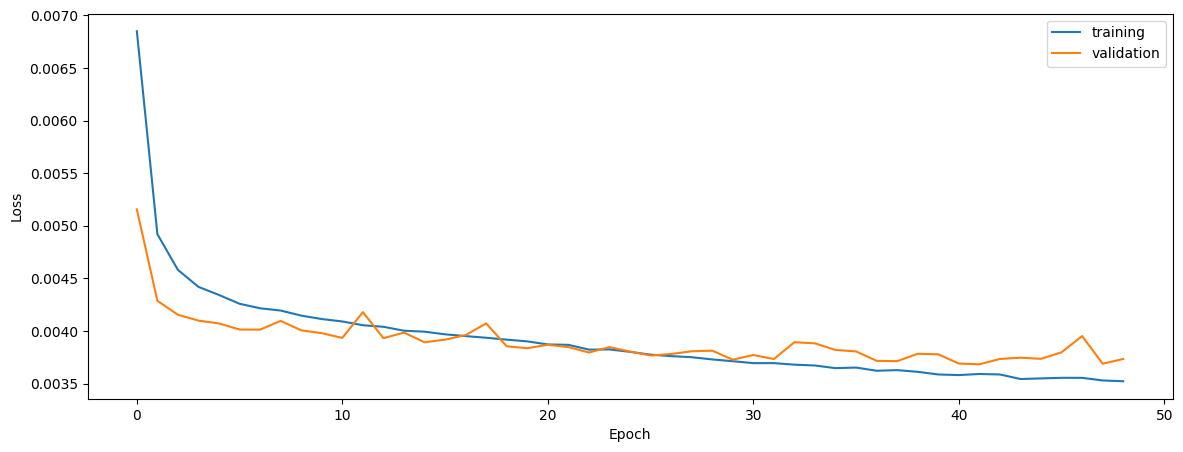

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.8032728471597688
0.7808743629846867
0.7897019854522943


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.8032728471597688
0.7808743629846867
0.7897019854522943


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.8066489227596169
0.7814541515489536
0.7967483409323324


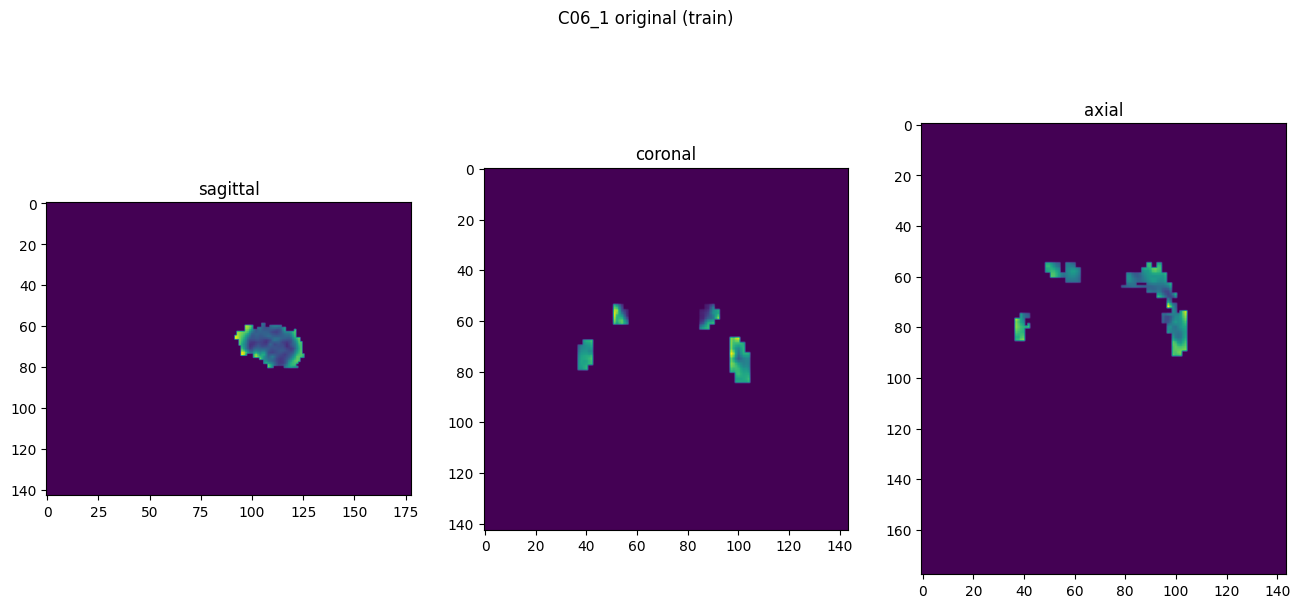

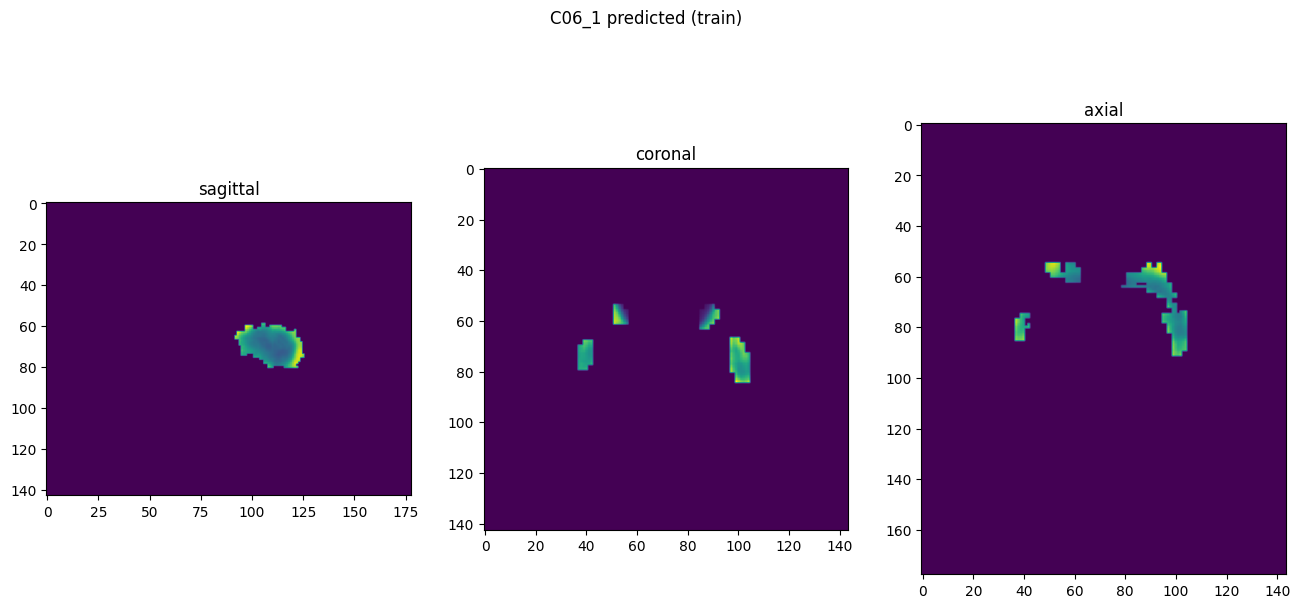

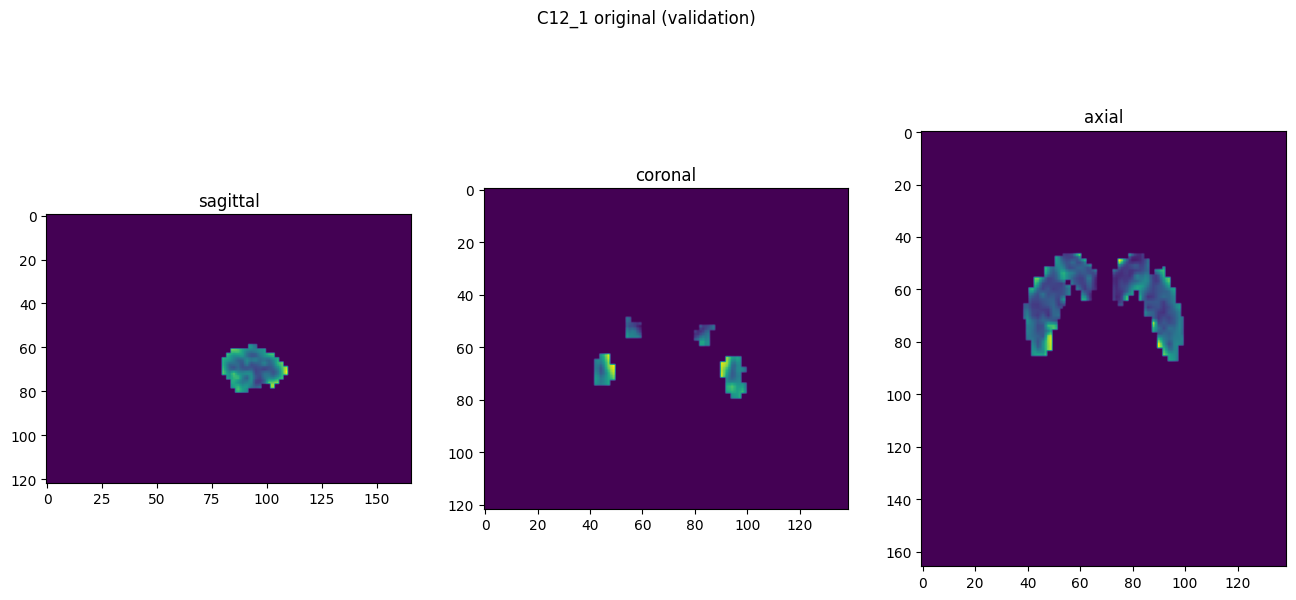

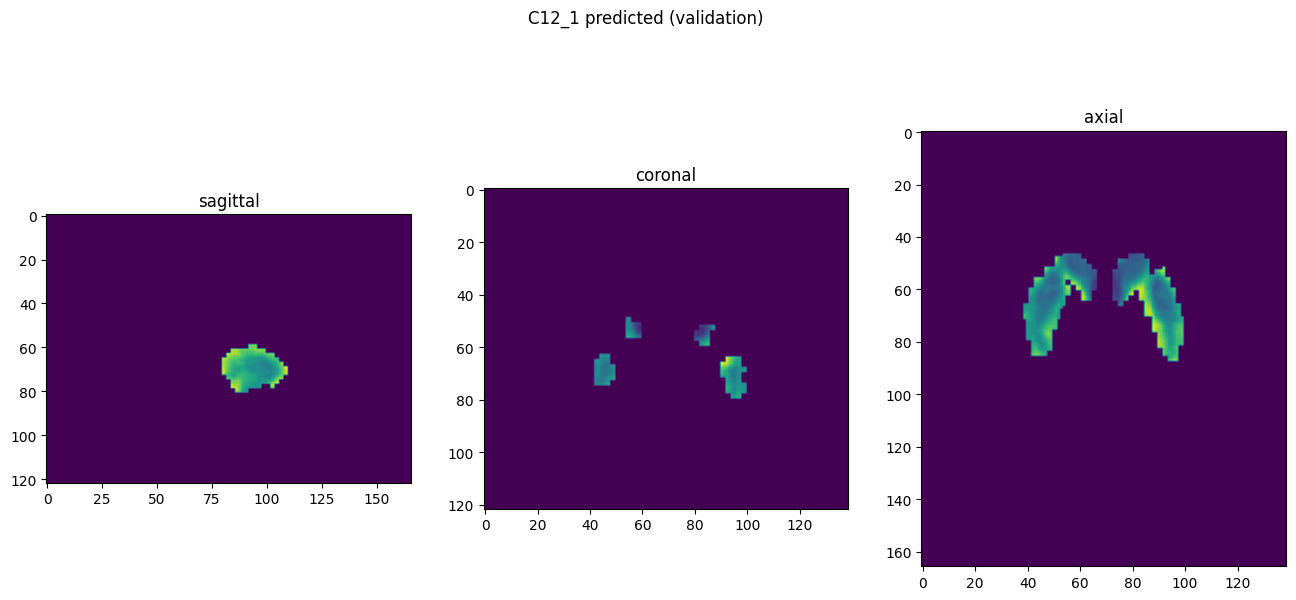

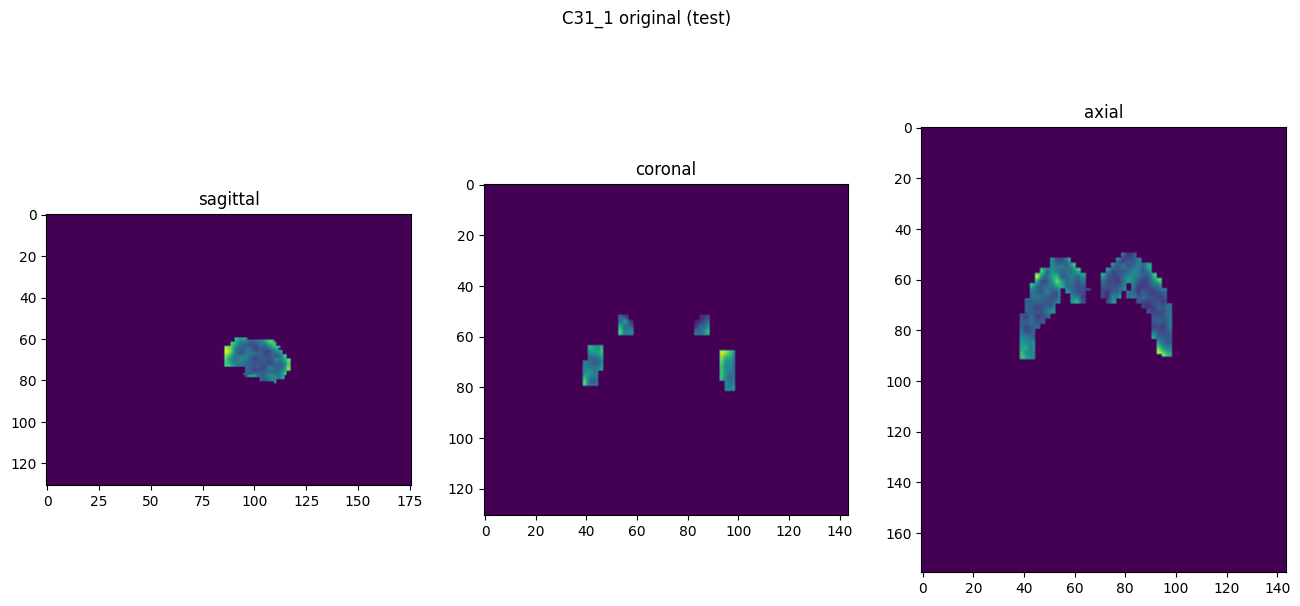

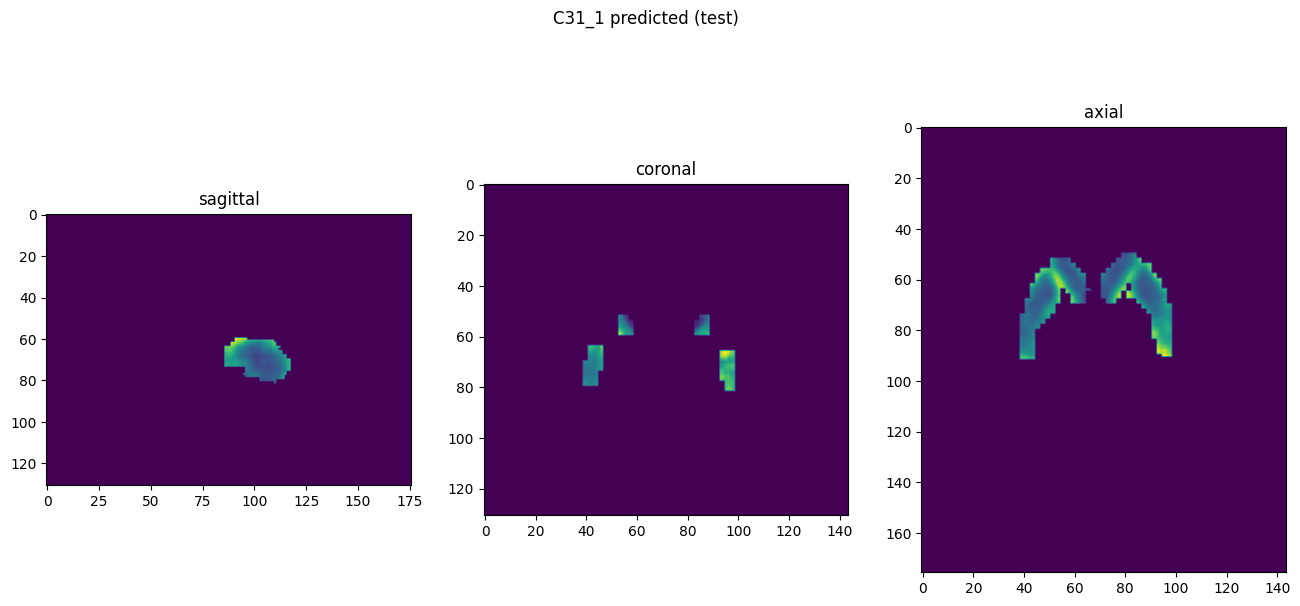

In [10]:
showResults(model, gen, threshold=None, background=False)